## Detecção de anomalias através da Transformada Wavelet Discreta (DWT)

### Carga das bibliotecas necessárias e da base de dados de exemplos do Harbinger

In [1]:
source("header.R")
library(ggplot2)
library("harbinger")
library(caret)
data(har_examples)

options(repr.plot.width = 12, repr.plot.height = 6)

Loading required package: usethis


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename



Attaching package: ‘TSPred’


The following object is masked from ‘package:base’:

    subset



Attaching package: ‘daltoolbox’


The following objects are masked from ‘package:TSPred’:

    evaluate, minmax


The following object is masked from ‘package:base’:

    transform



Attaching package: ‘harbinger’


The following object is masked _by_ ‘.GlobalEnv’:

    har_plot



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:daltoolbox’:

    cluster


The following object is masked from ‘package

## Teste com as séries sintéticas

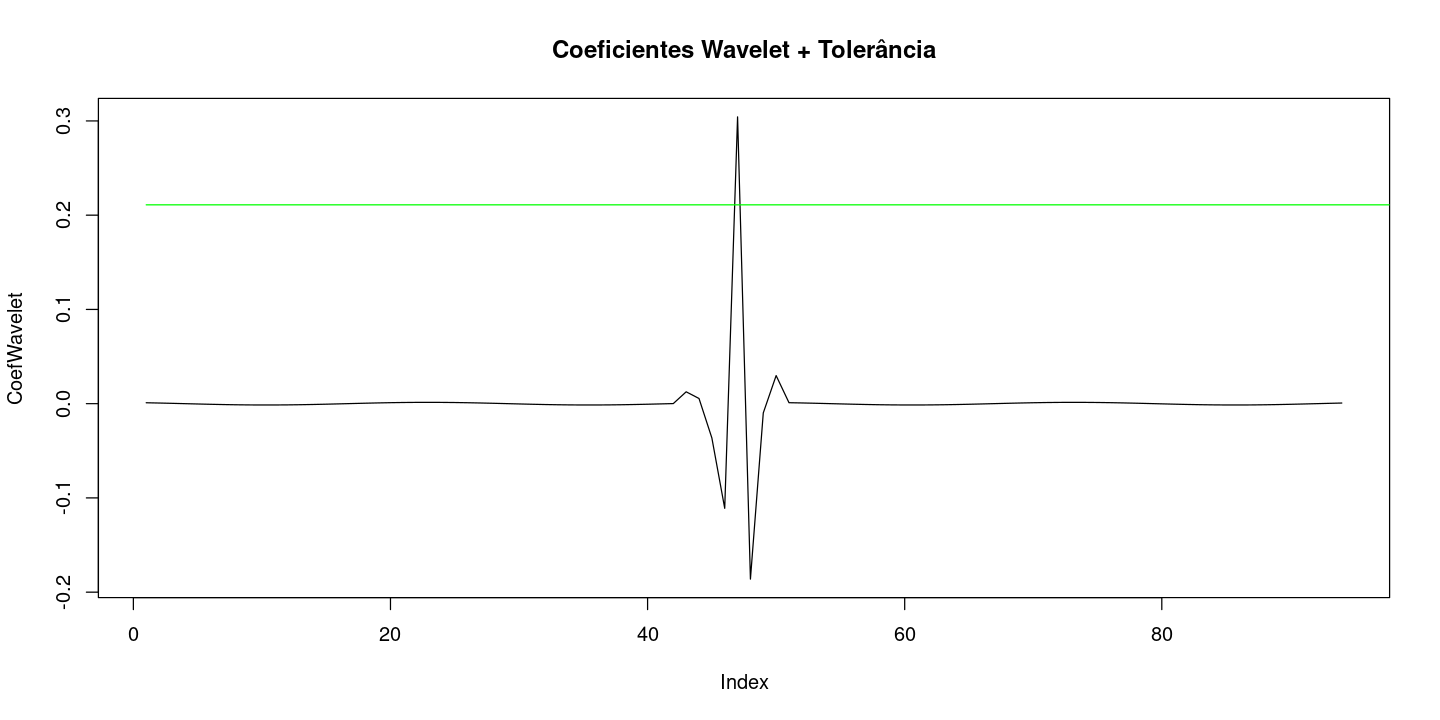

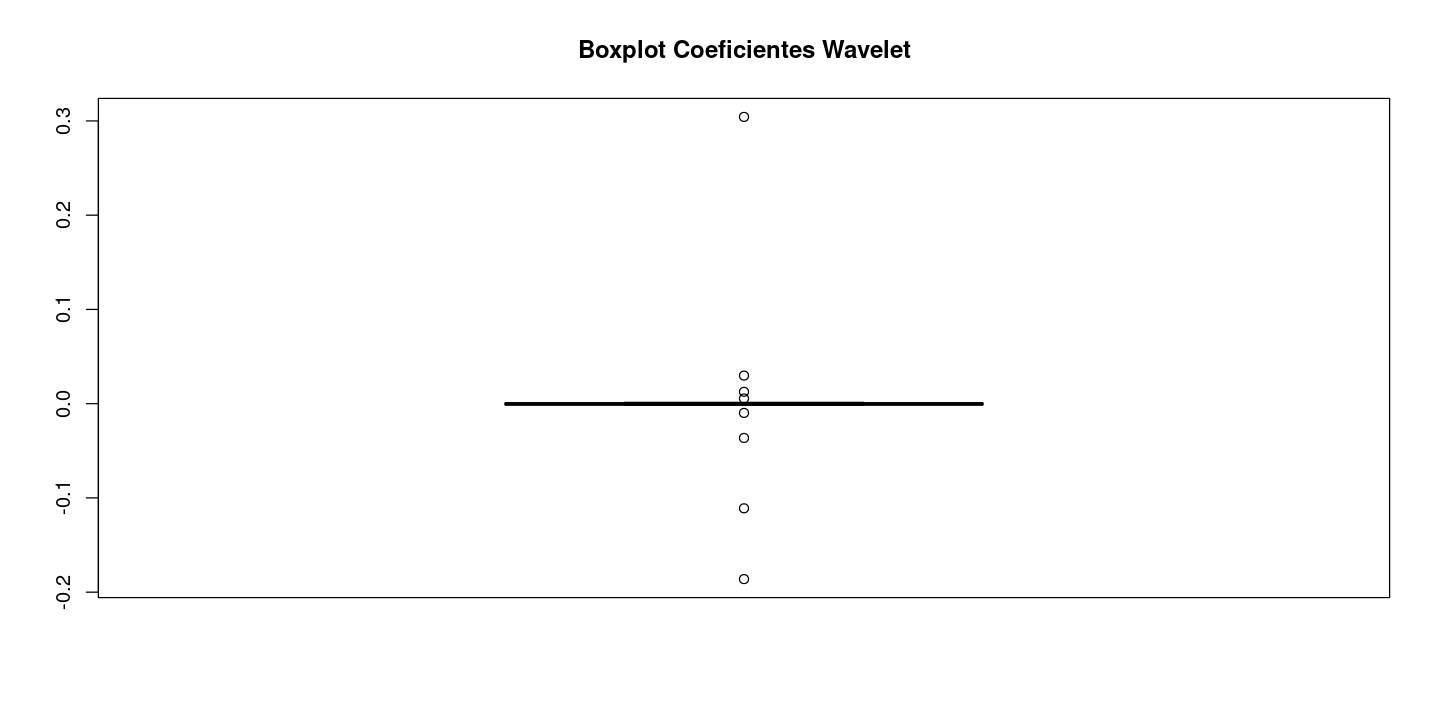

[1] "Candidatos à anomalias:"
[1] 46 47 48 49 50 51 52 53
[1] "Anomalias por frequência + amplitude:"
[1] 47 48 49 50 51 52 53
[1] "Anomalias por frequência:"
[1] 50


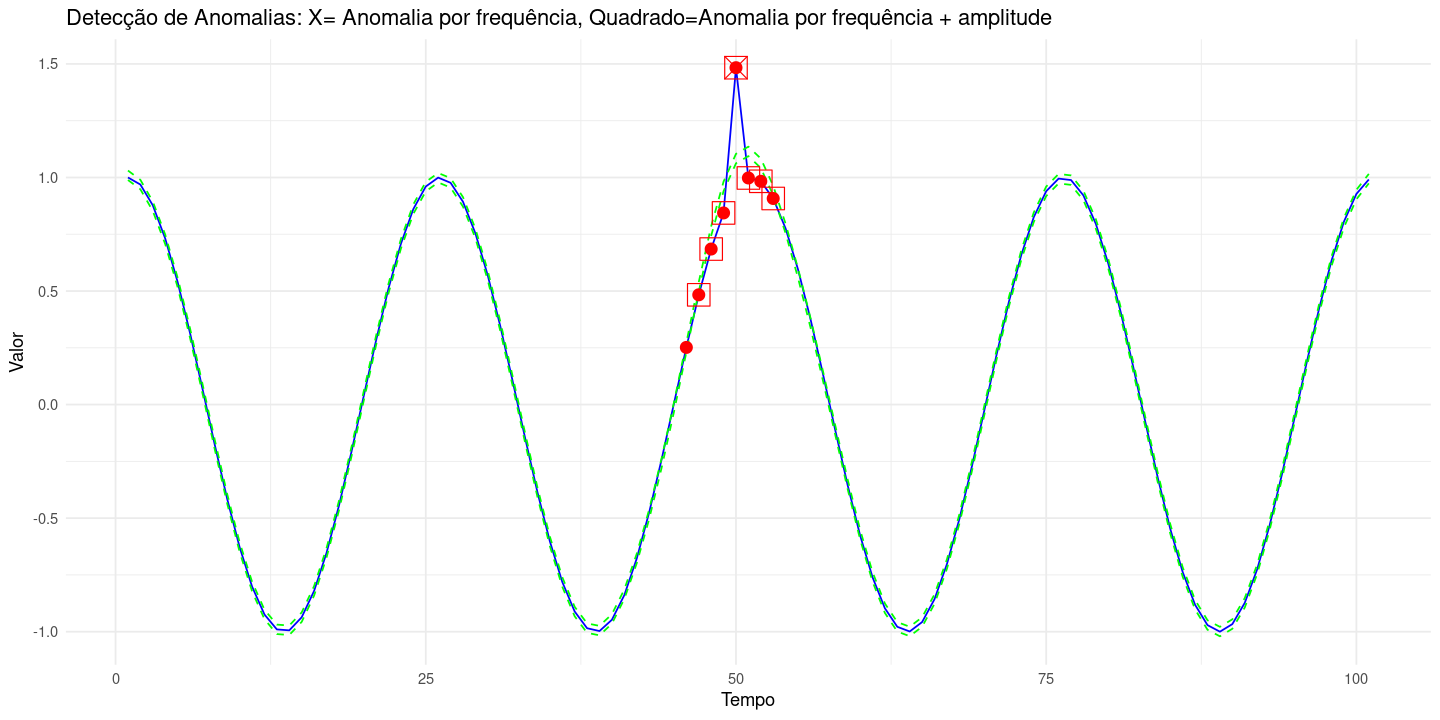

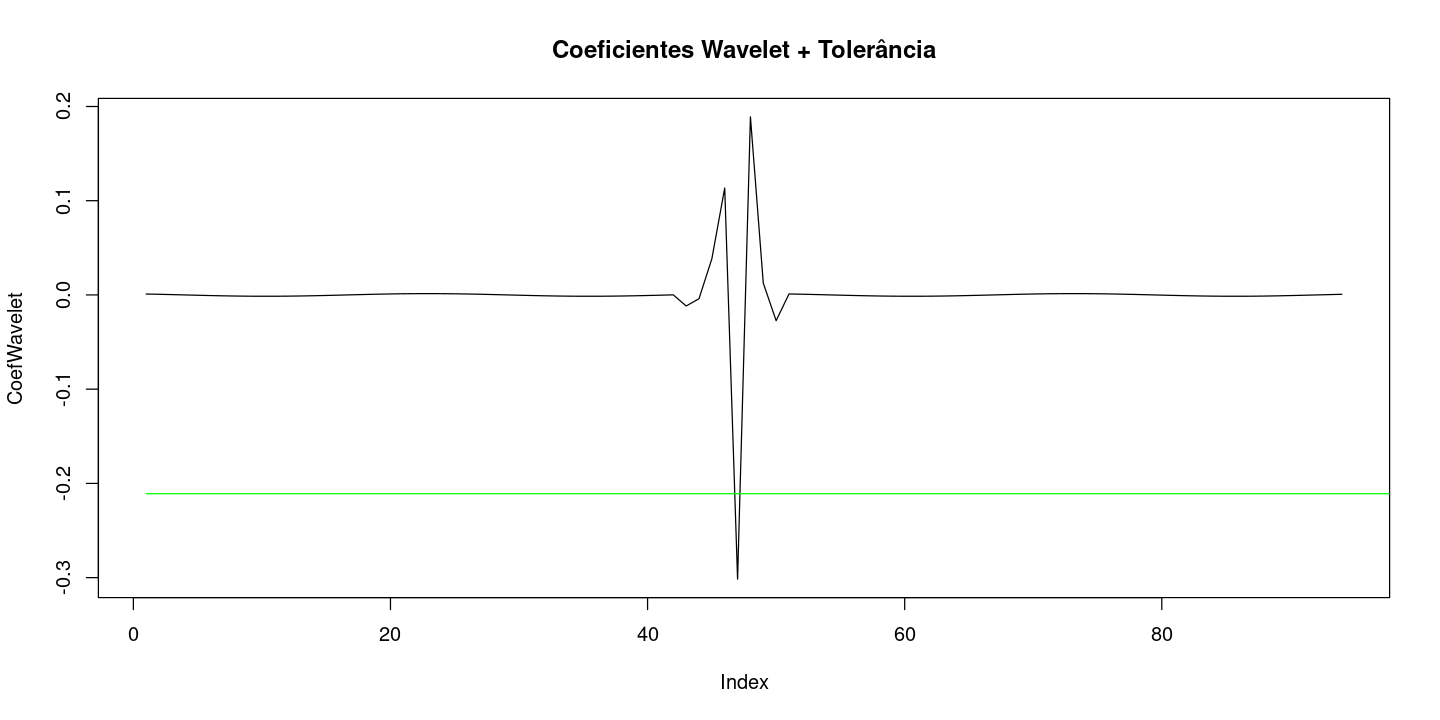

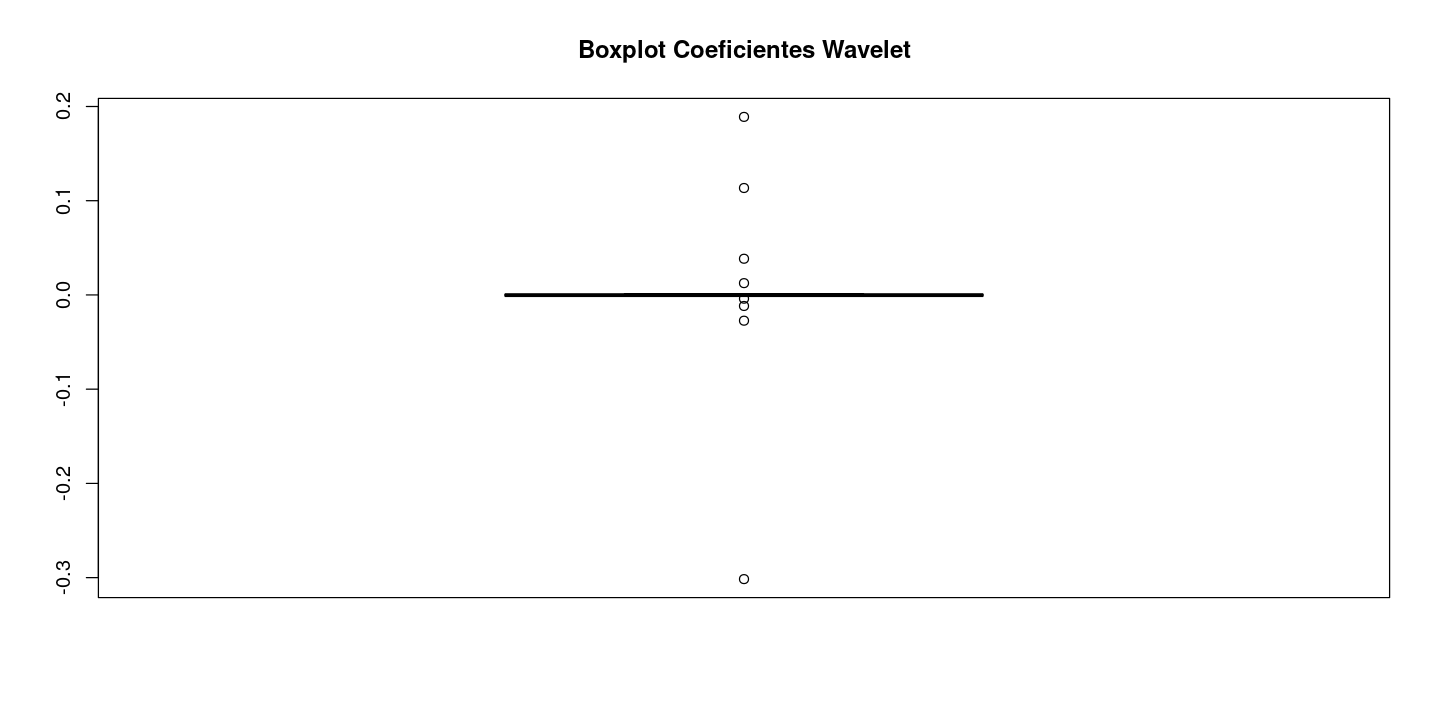

[1] "Candidatos à anomalias:"
[1] 46 47 48 49 50 51 52 53
[1] "Anomalias por frequência + amplitude:"
[1] 47 48 49 50 51 52 53
[1] "Anomalias por frequência:"
[1] 50


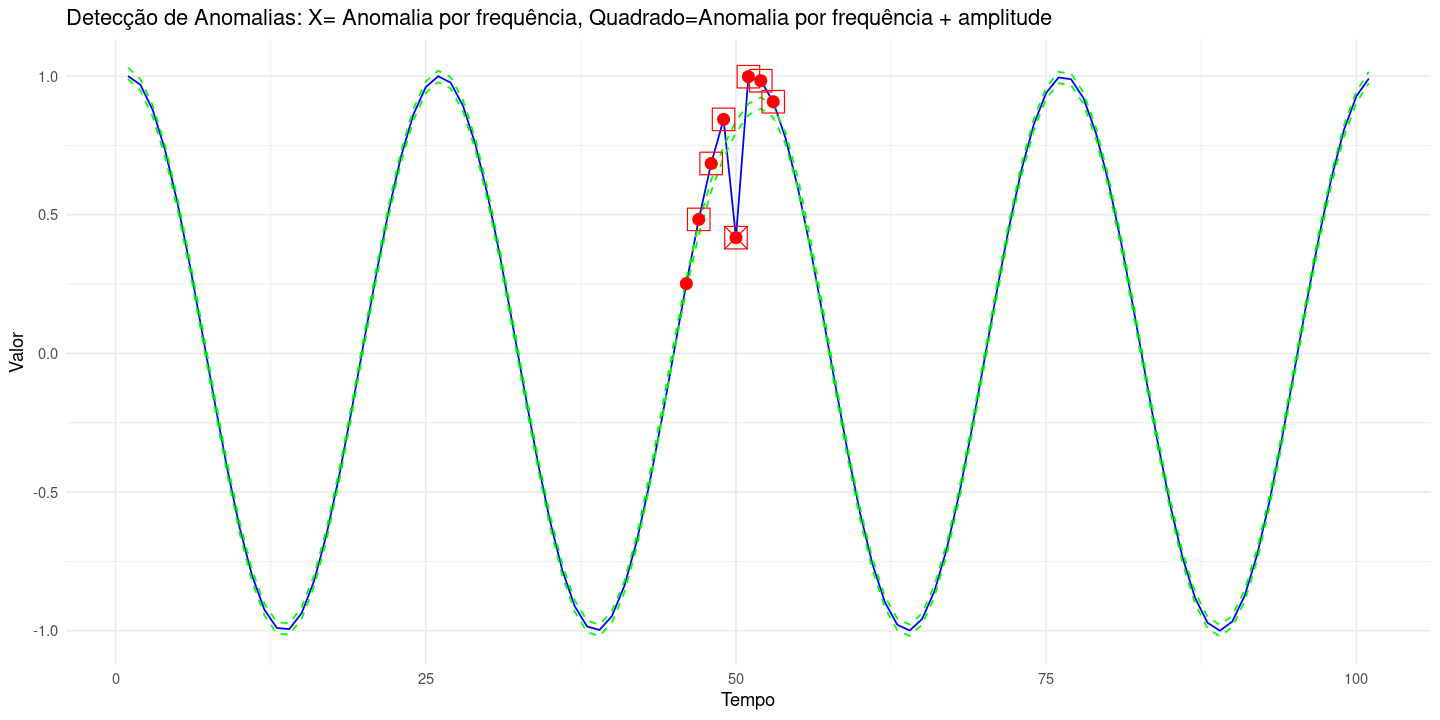

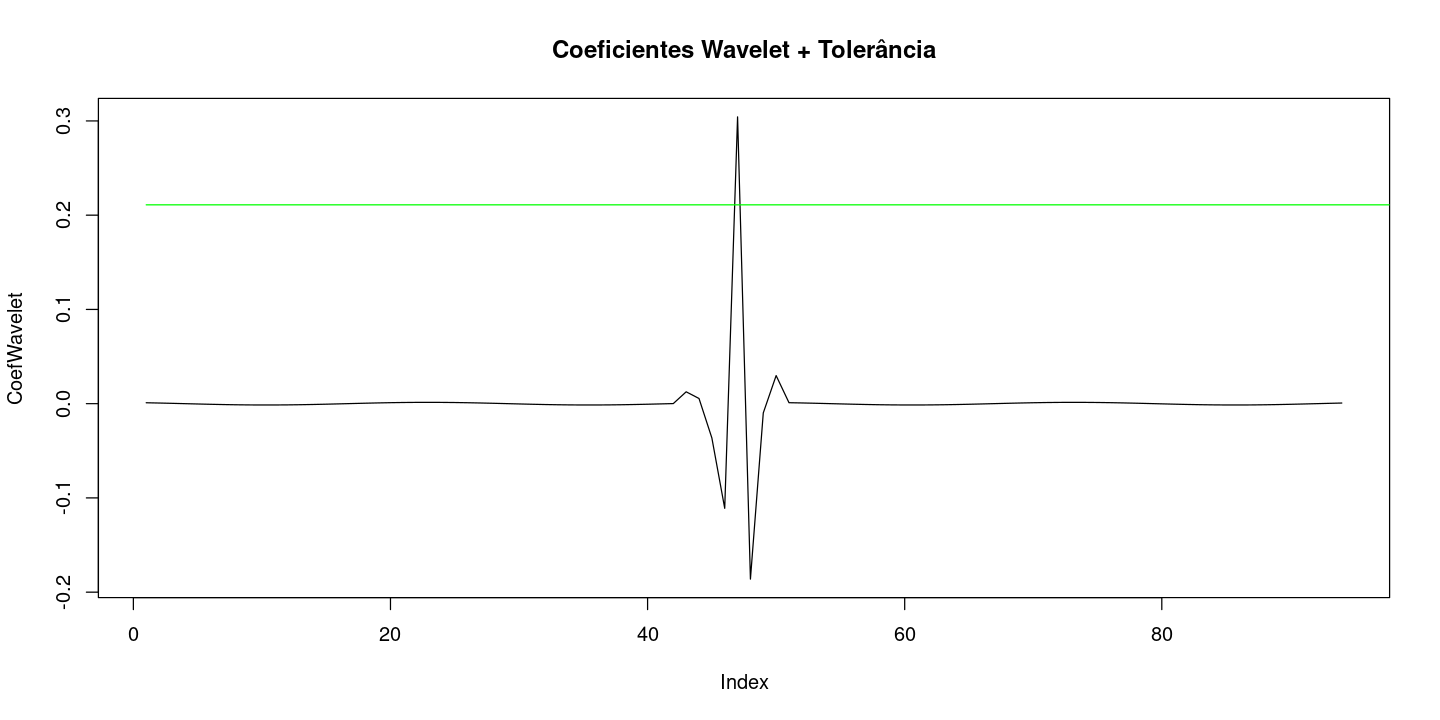

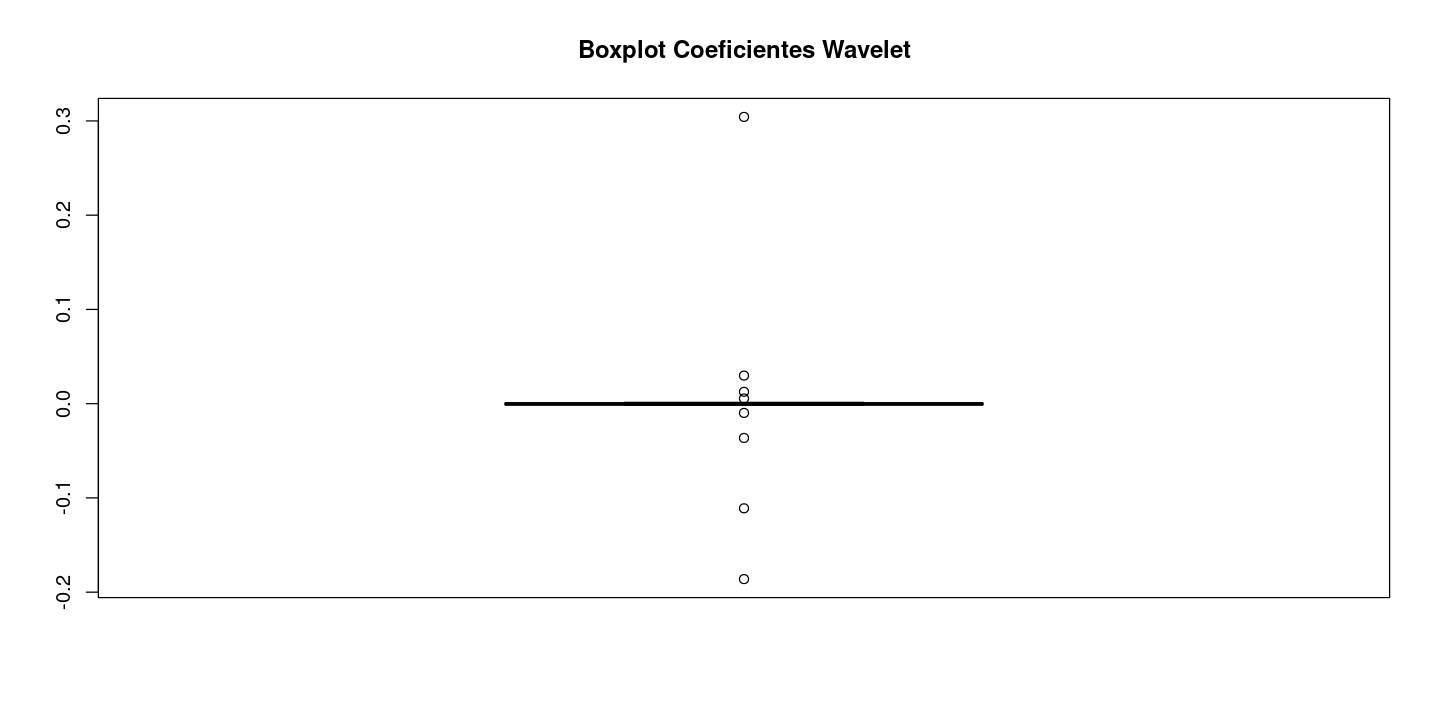

[1] "Candidatos à anomalias:"
[1] 46 47 48 49 50 51 52 53
[1] "Anomalias por frequência + amplitude:"
NULL
[1] "Anomalias por frequência:"
[1] 50


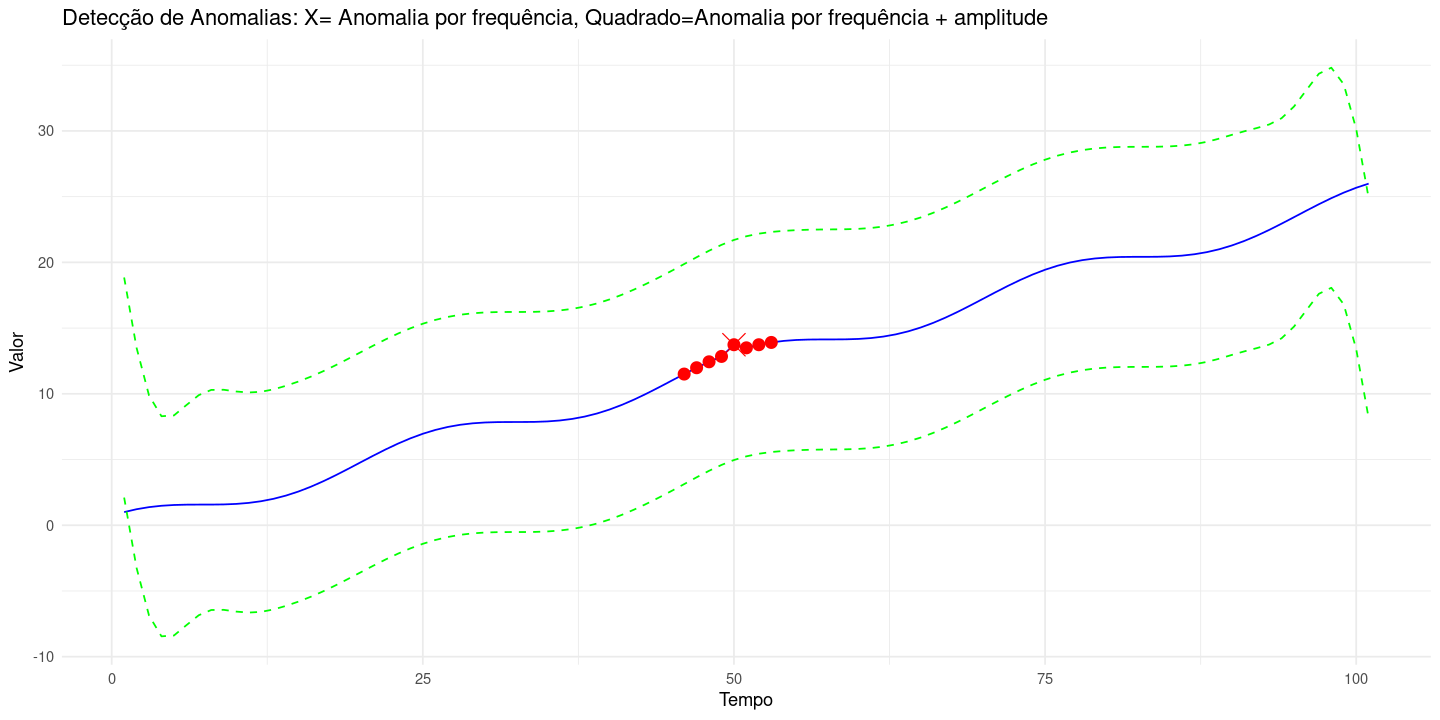

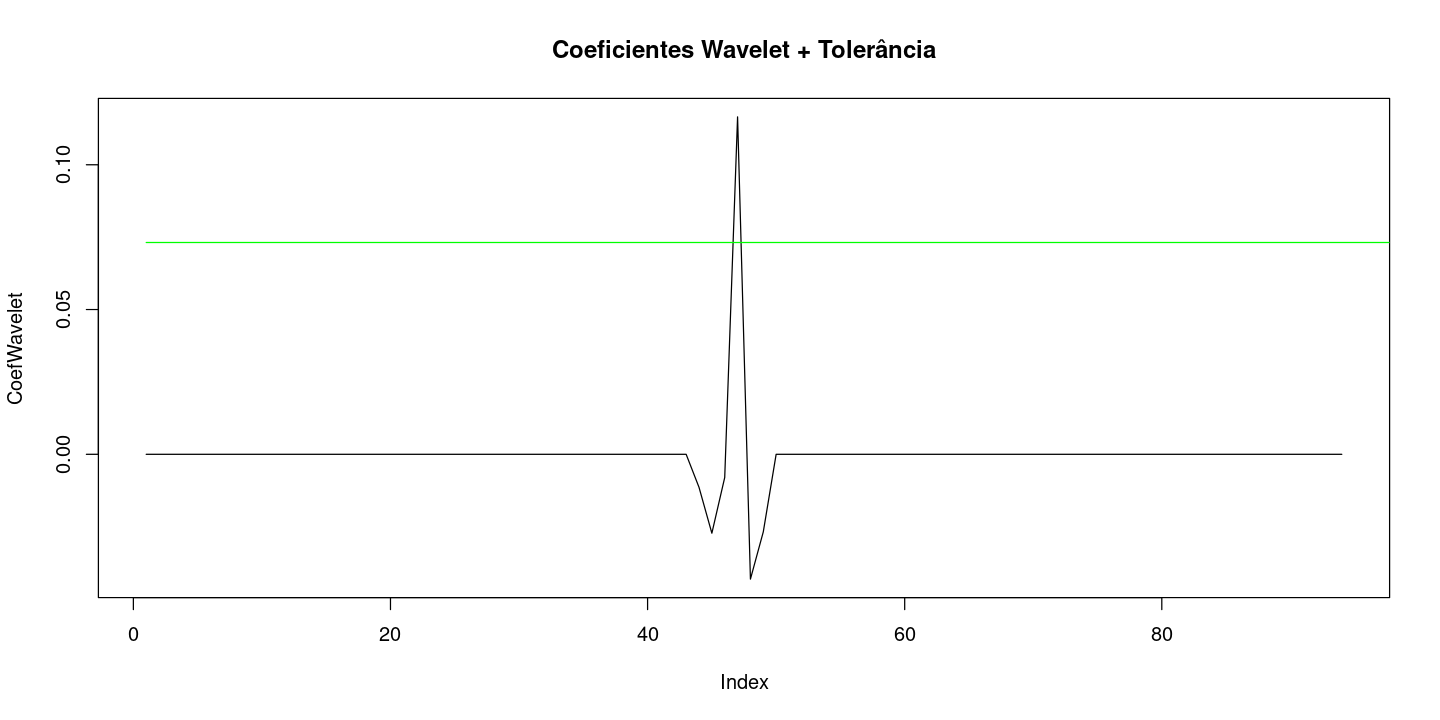

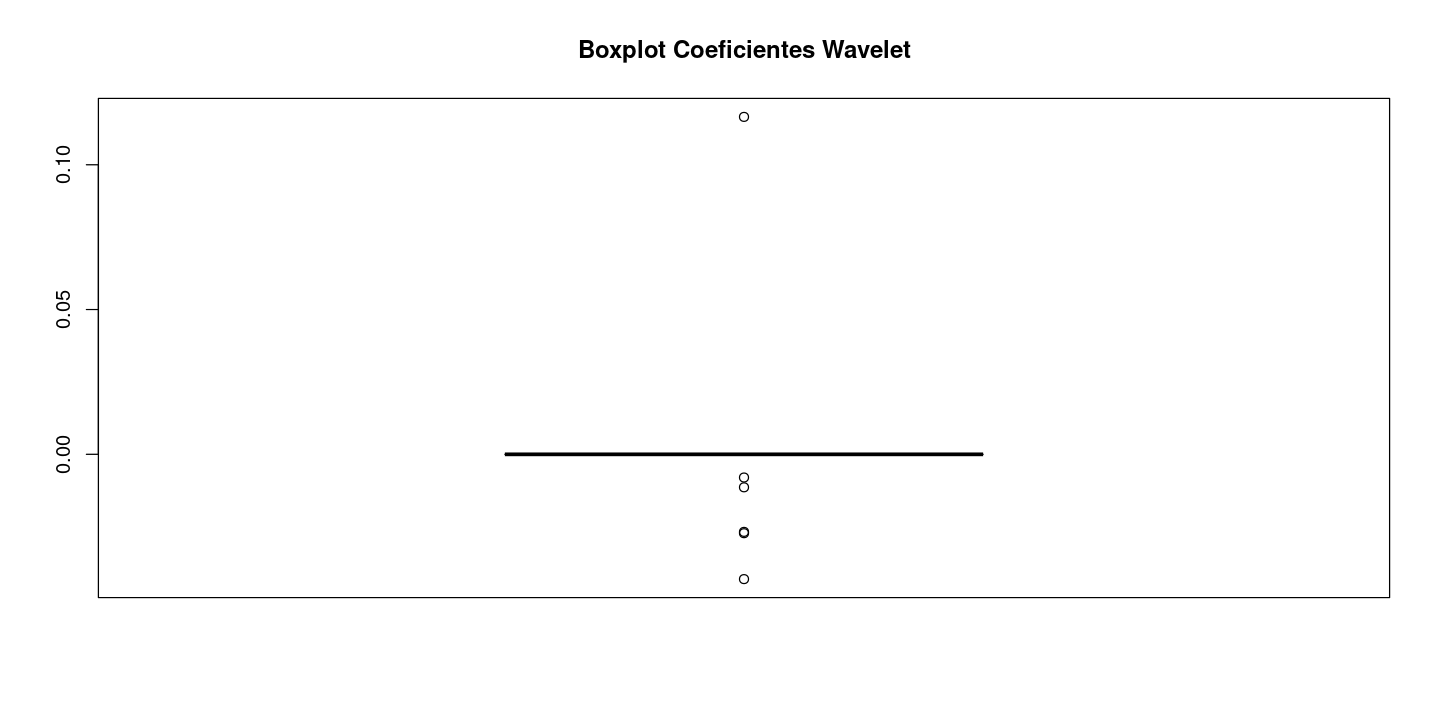

[1] "Candidatos à anomalias:"
[1] 47 48 49 50 51 52
[1] "Anomalias por frequência + amplitude:"
[1] 50
[1] "Anomalias por frequência:"
[1] 50


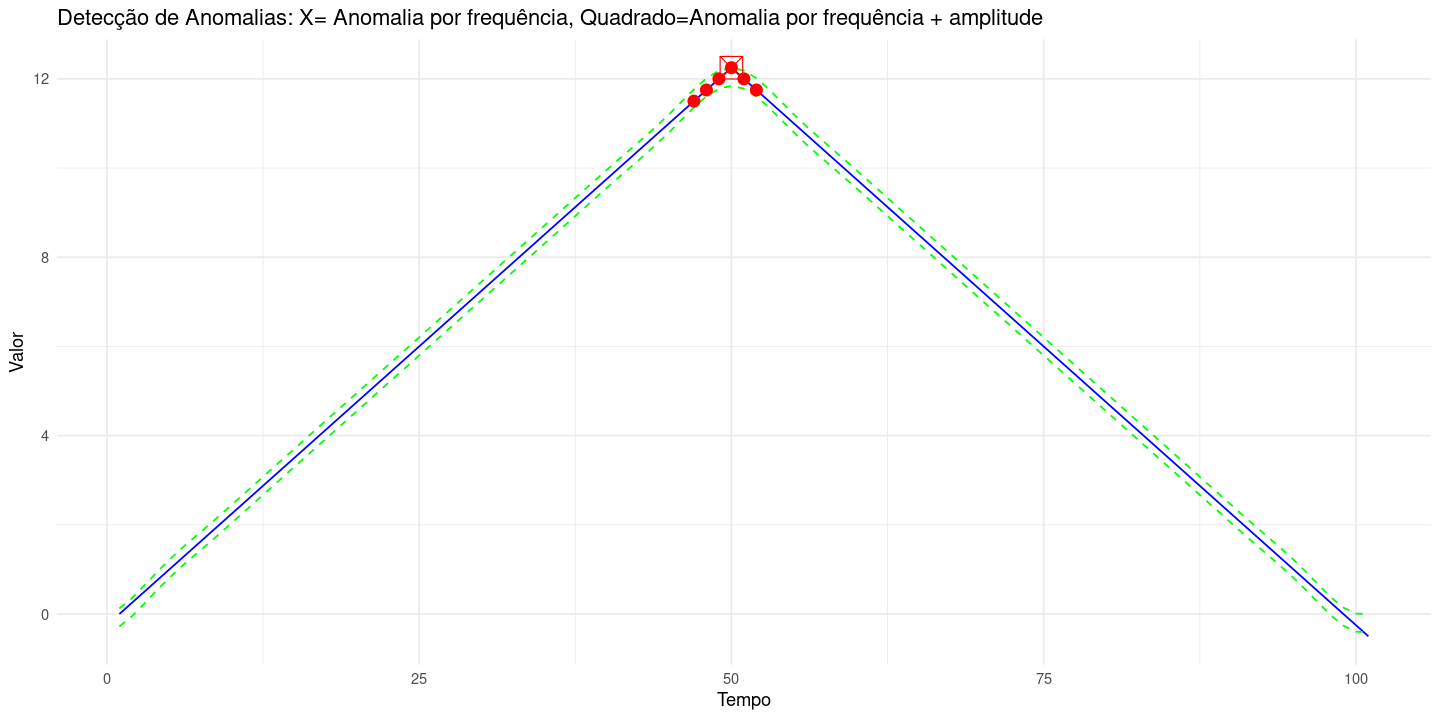

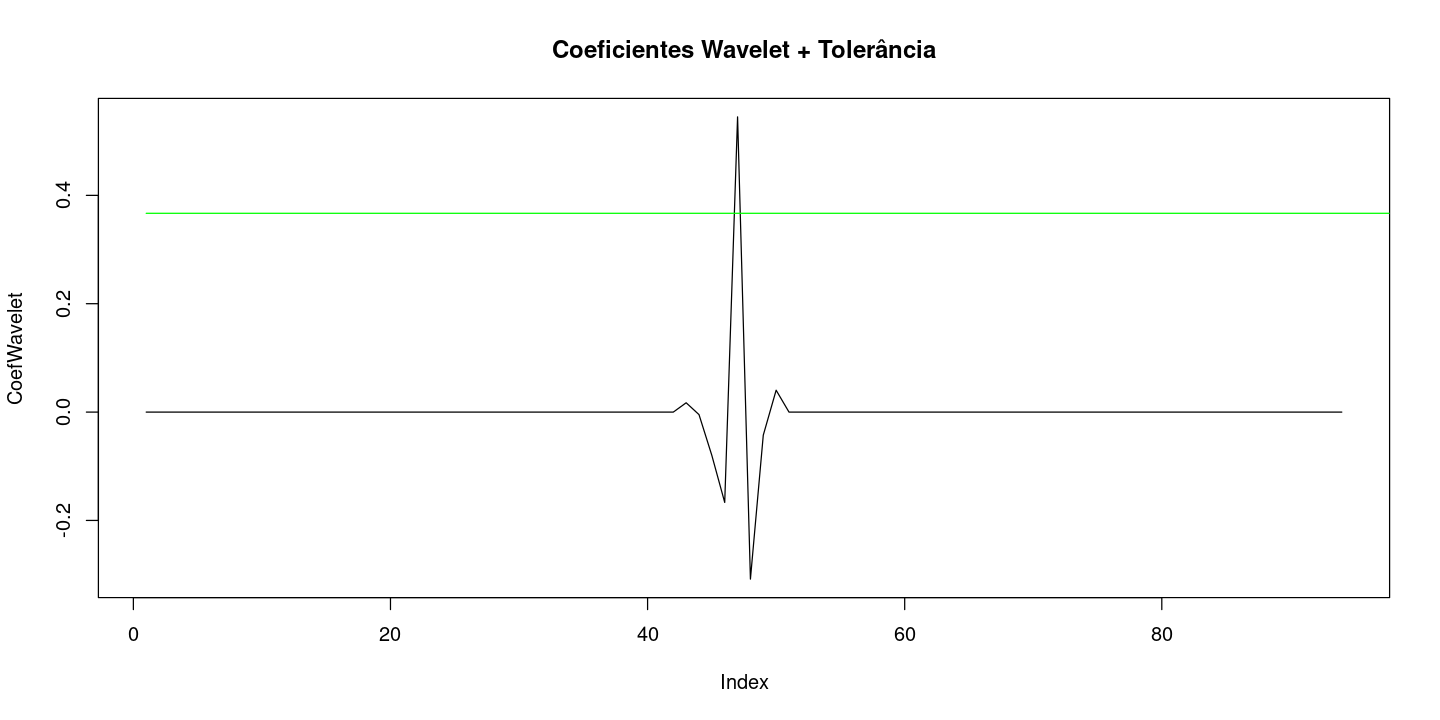

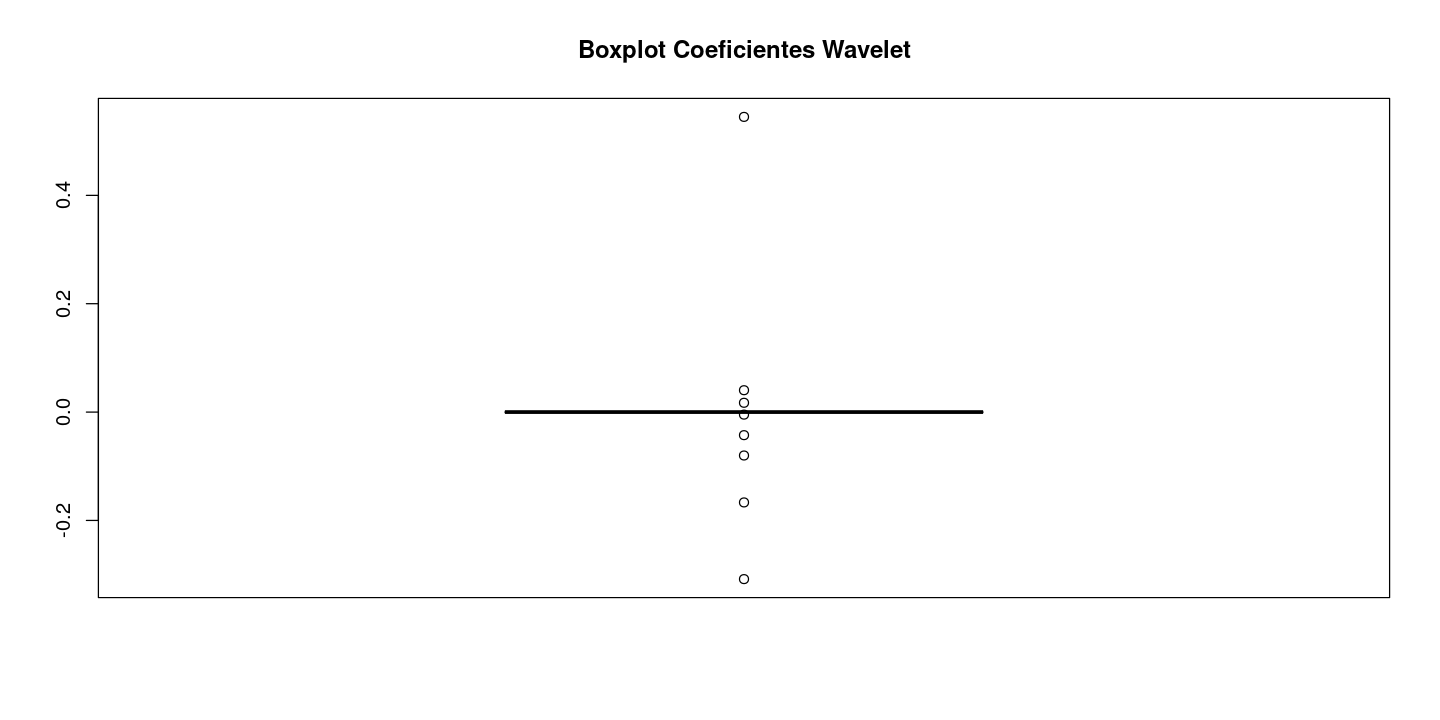

[1] "Candidatos à anomalias:"
[1] 46 47 48 49 50 51 52 53
[1] "Anomalias por frequência + amplitude:"
[1] 50
[1] "Anomalias por frequência:"
[1] 50


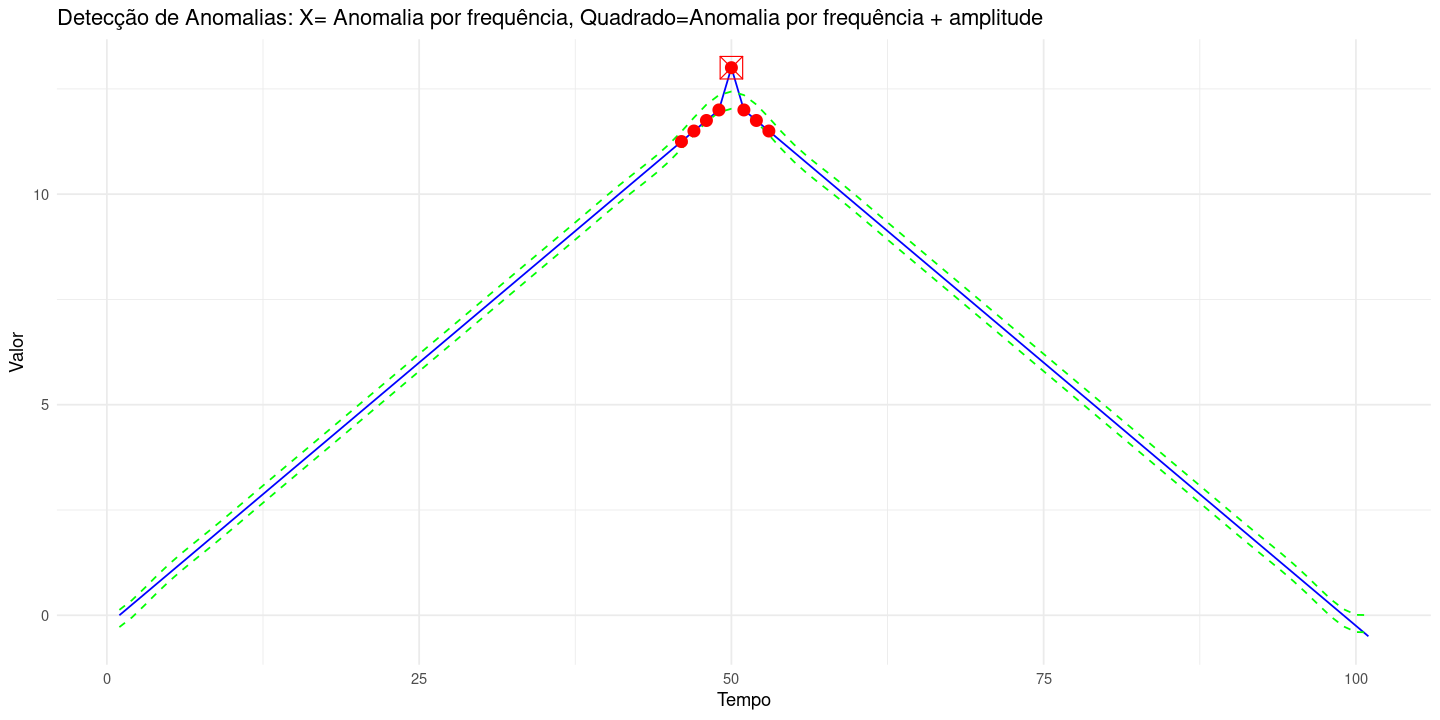

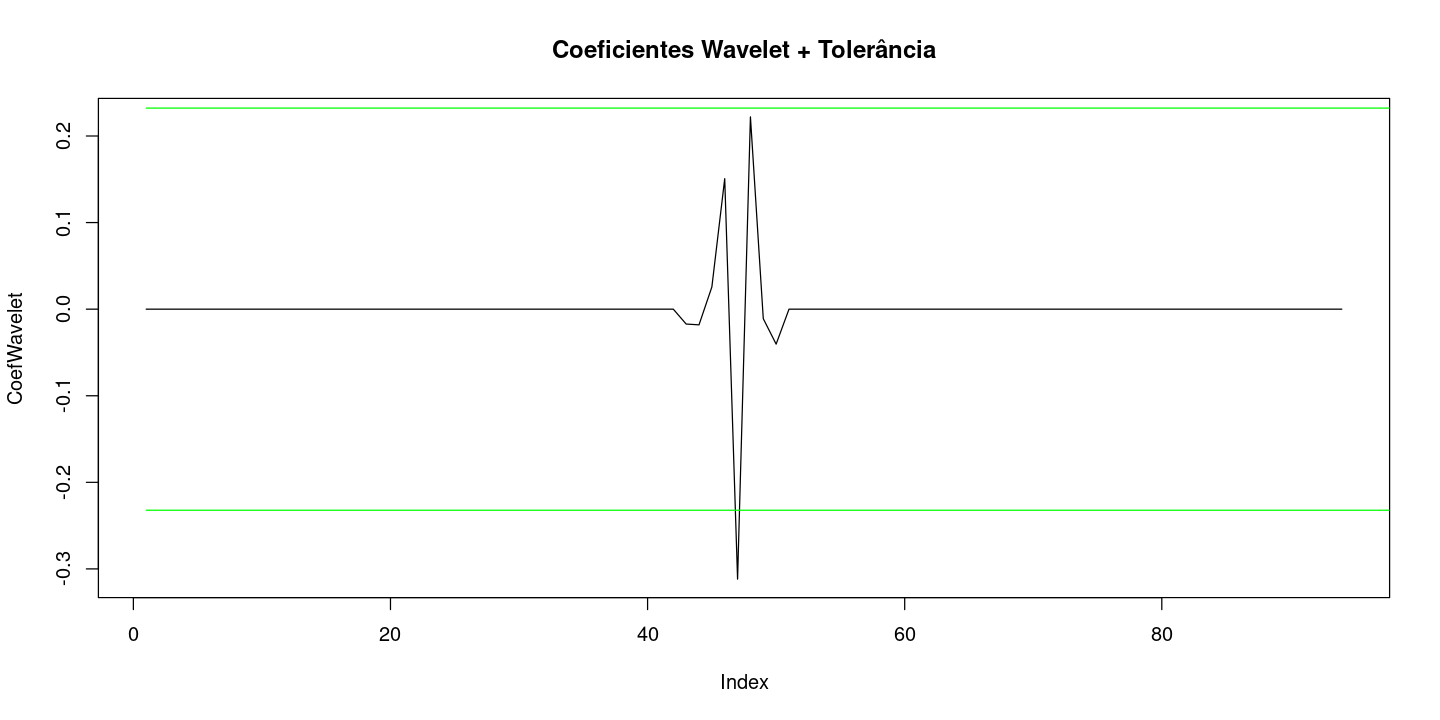

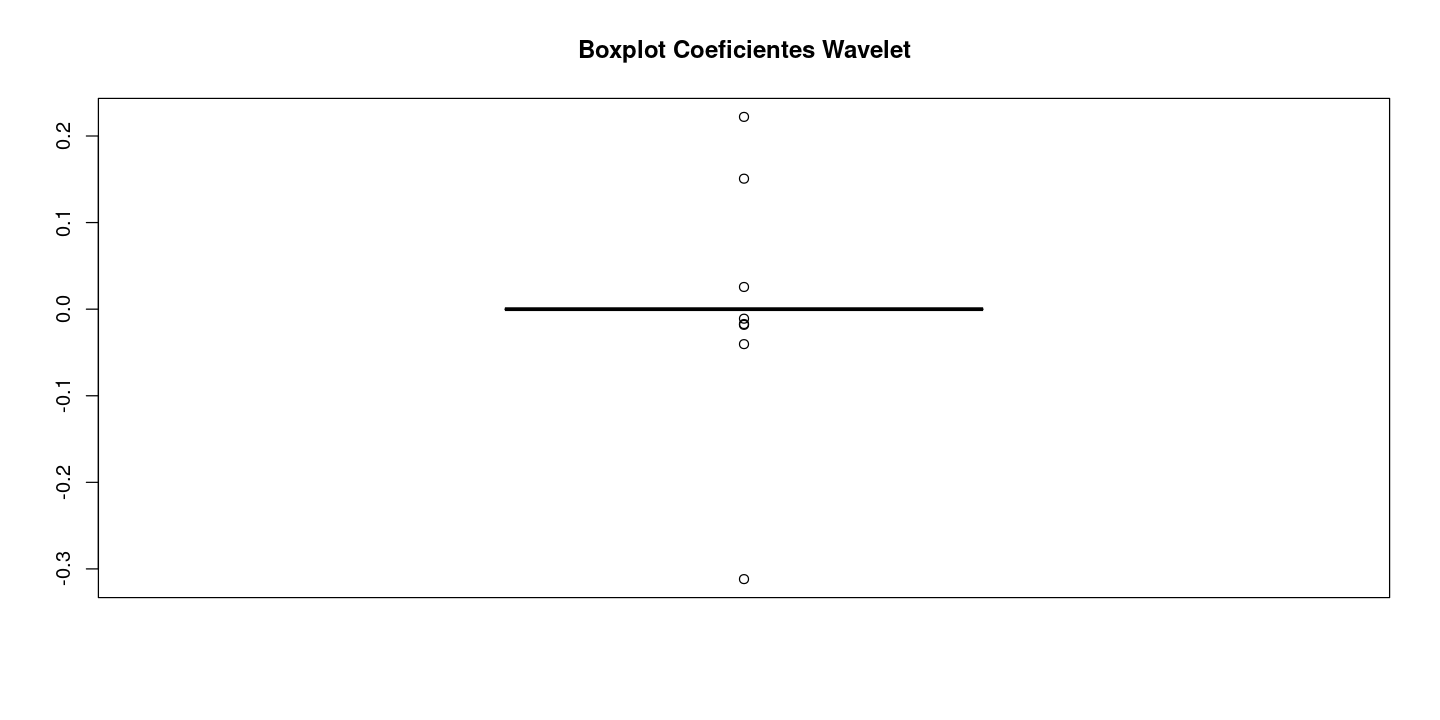

[1] "Candidatos à anomalias:"
[1] 46 47 48 49 50 51 52 53
[1] "Anomalias por frequência + amplitude:"
[1] 50
[1] "Anomalias por frequência:"
[1] 50


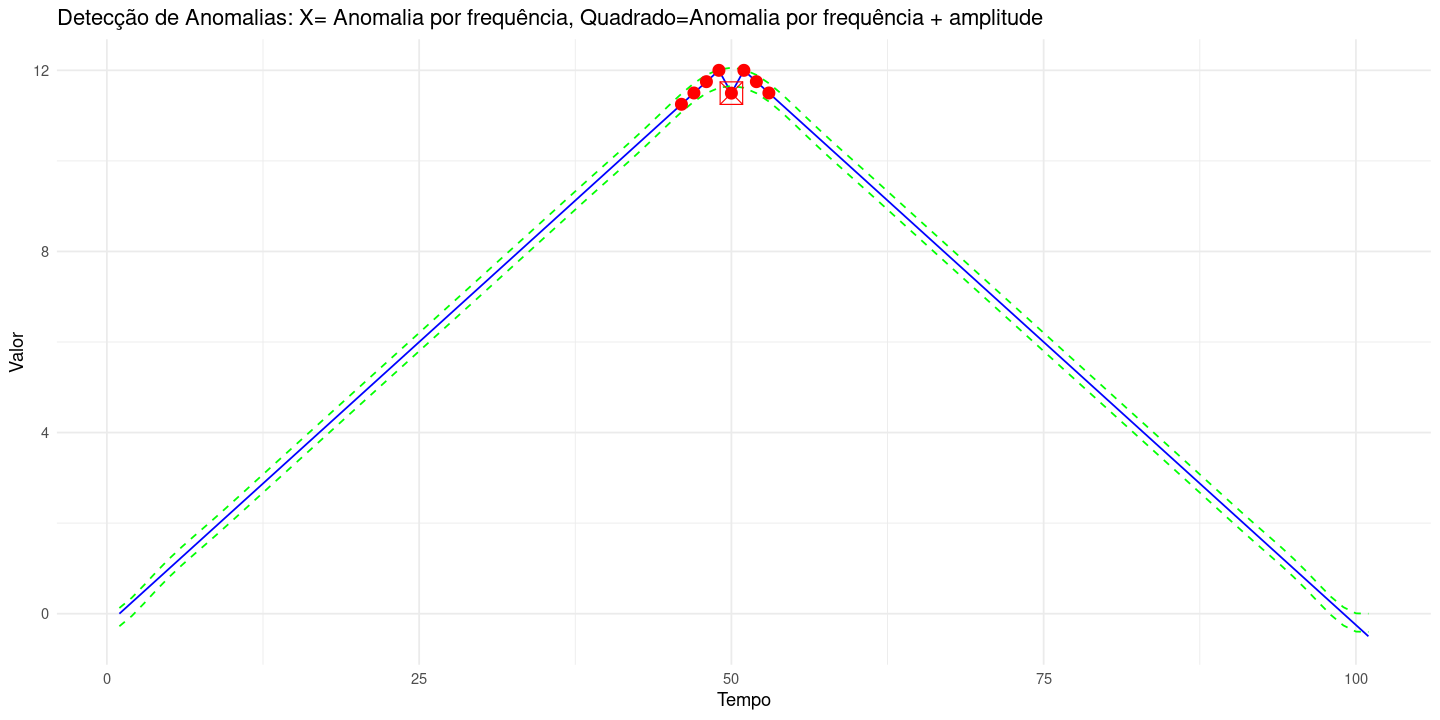

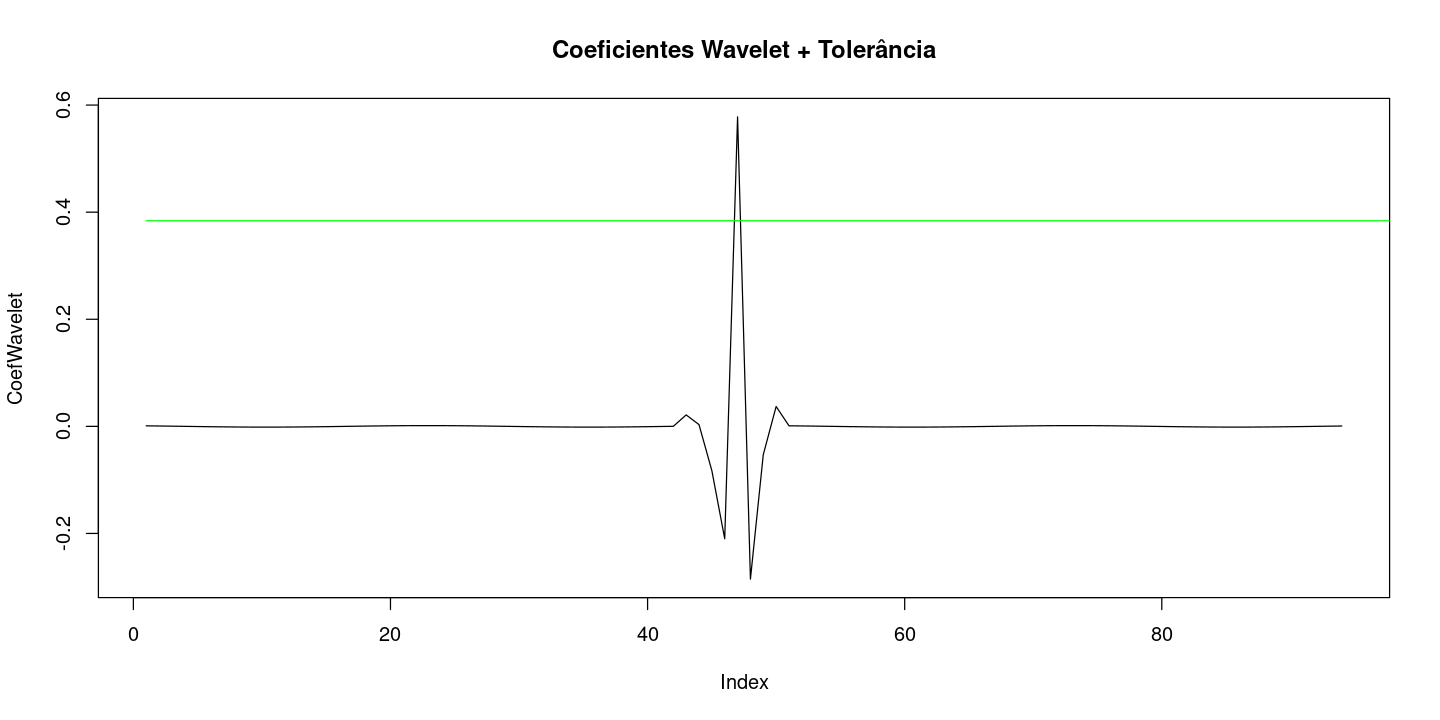

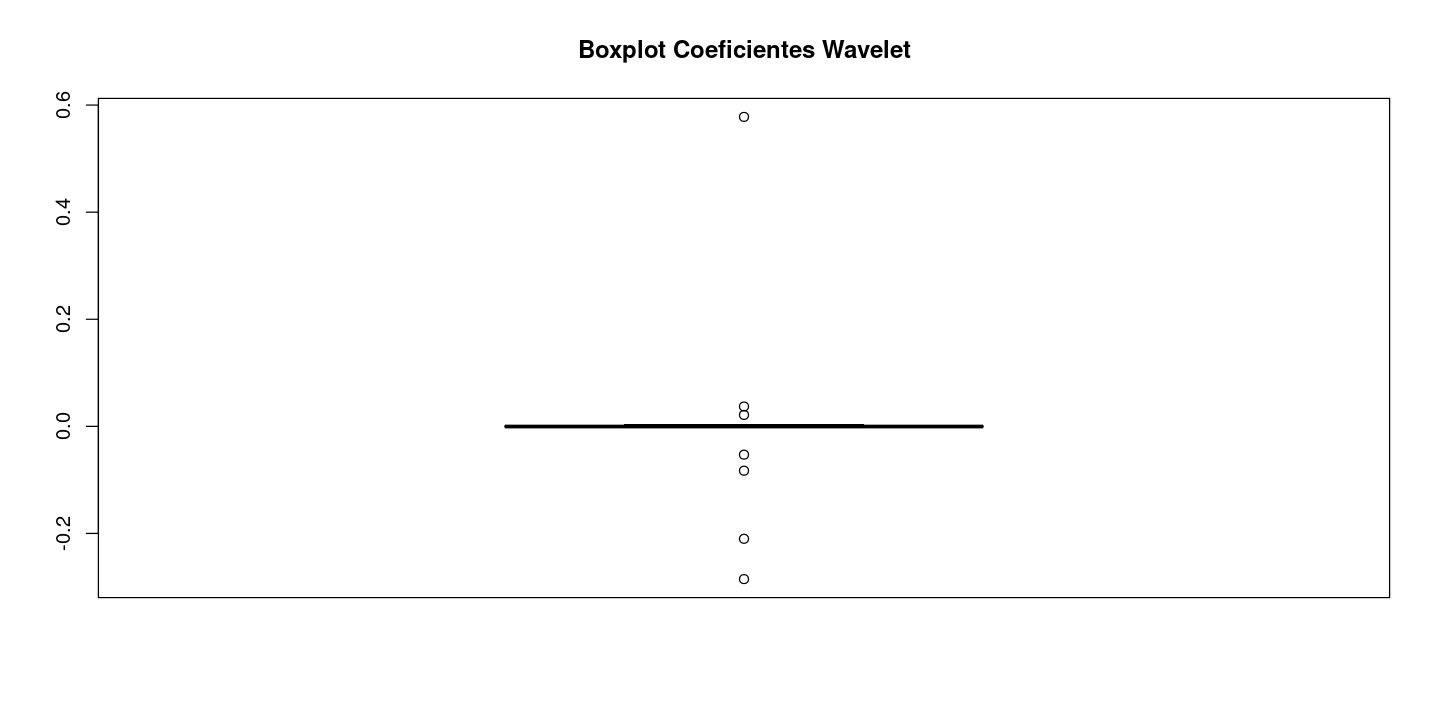

[1] "Candidatos à anomalias:"
[1] 46 48 49 50 51 52 53
[1] "Anomalias por frequência + amplitude:"
[1] 48 49 50
[1] "Anomalias por frequência:"
[1] 50


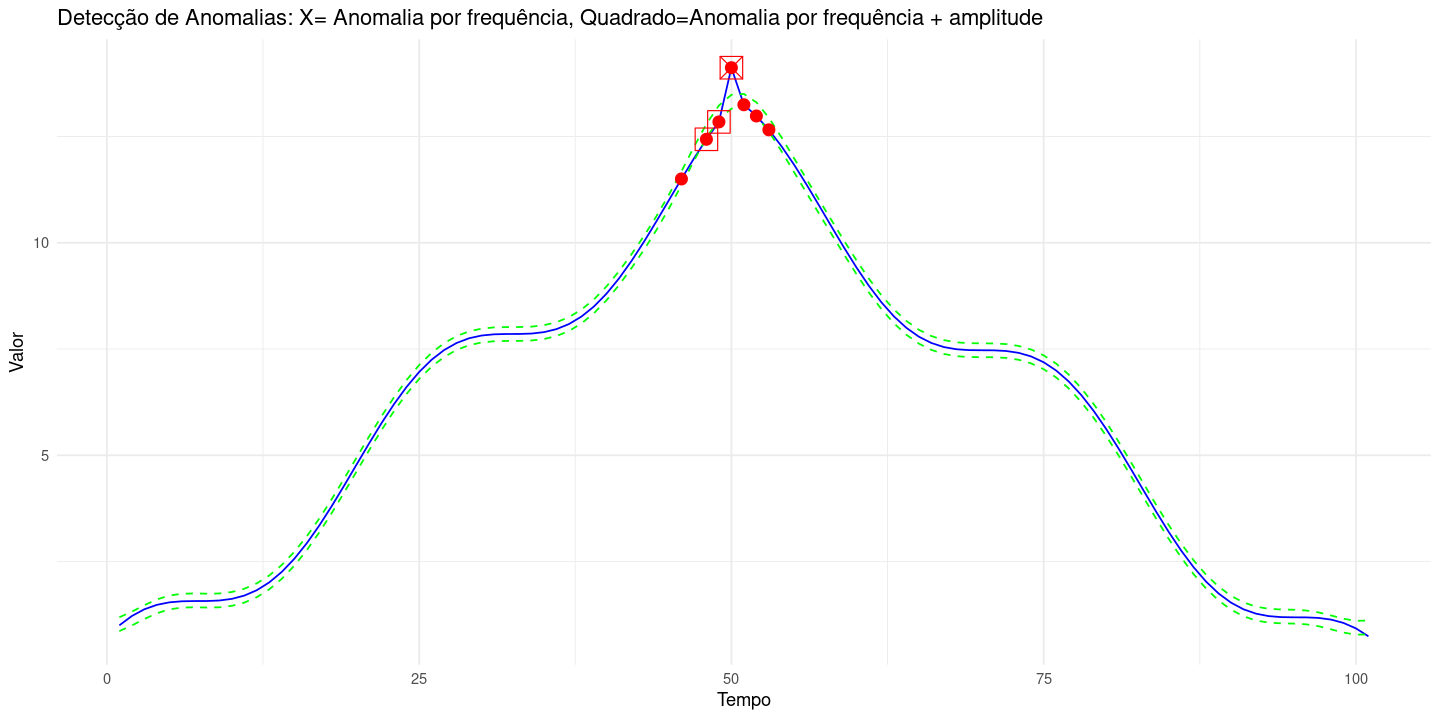

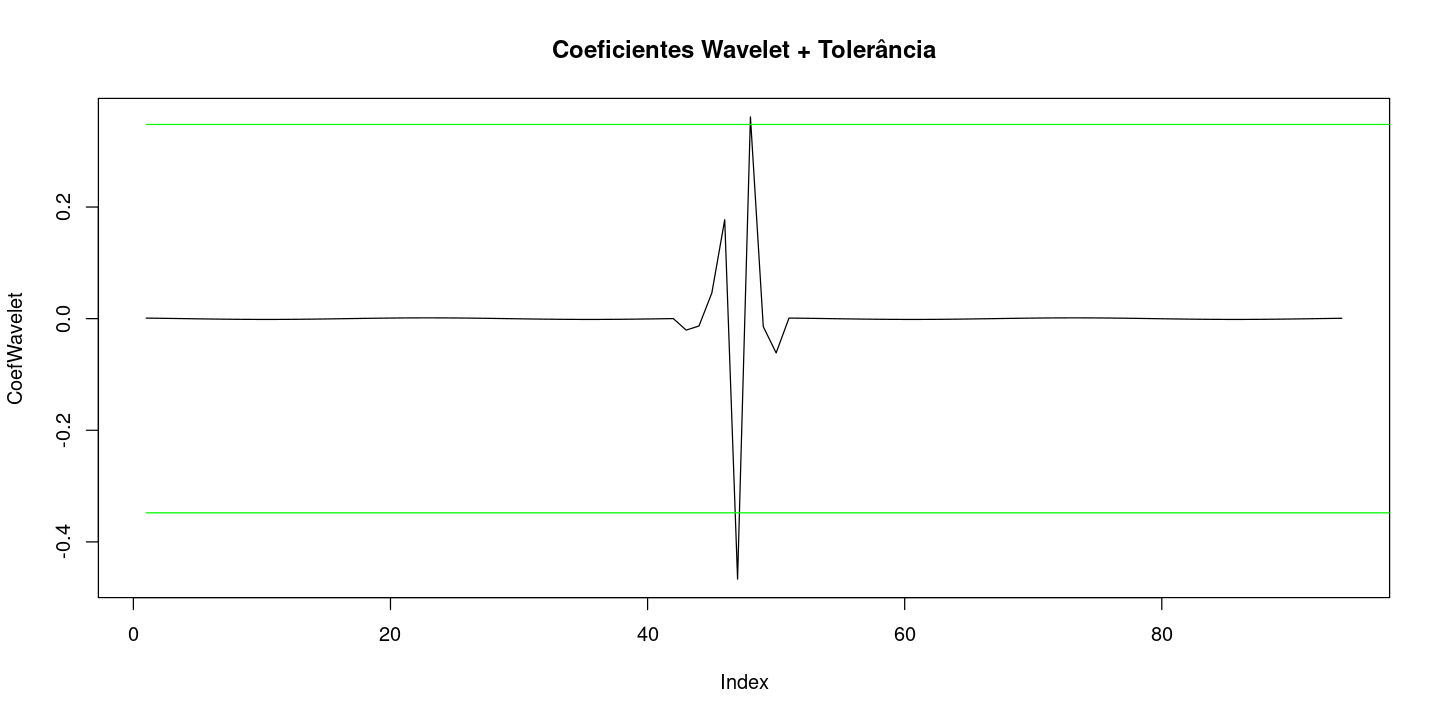

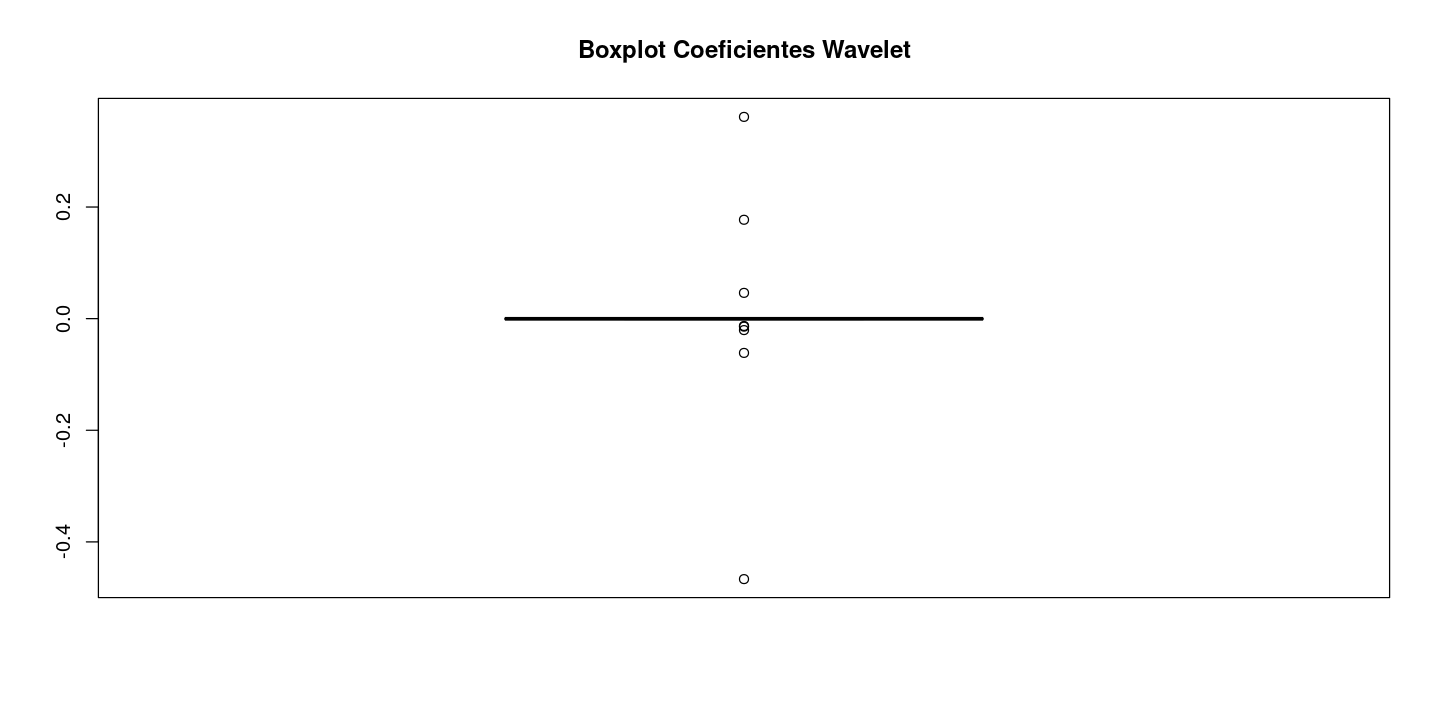

[1] "Candidatos à anomalias:"
[1] 46 47 48 49 50 51 52 53
[1] "Anomalias por frequência + amplitude:"
[1] 49 50 51
[1] "Anomalias por frequência:"
[1] 50 51


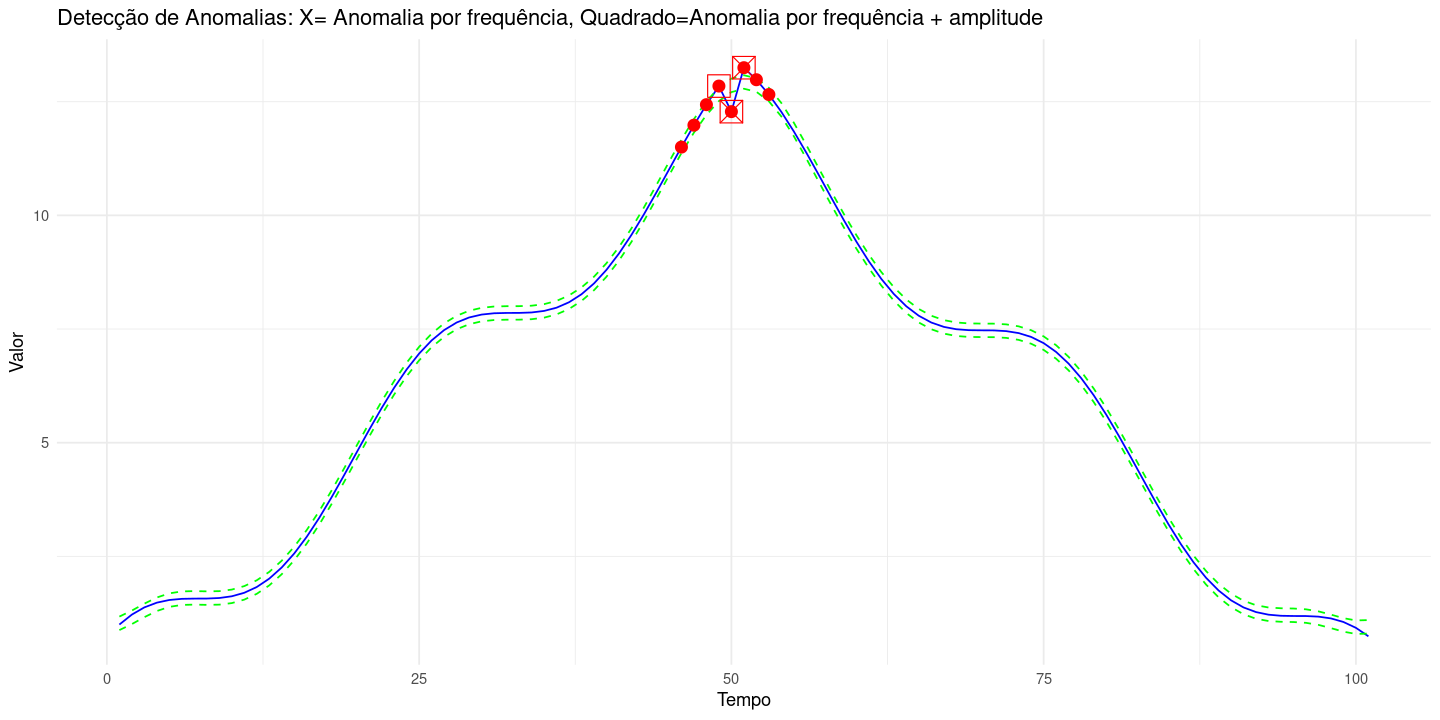

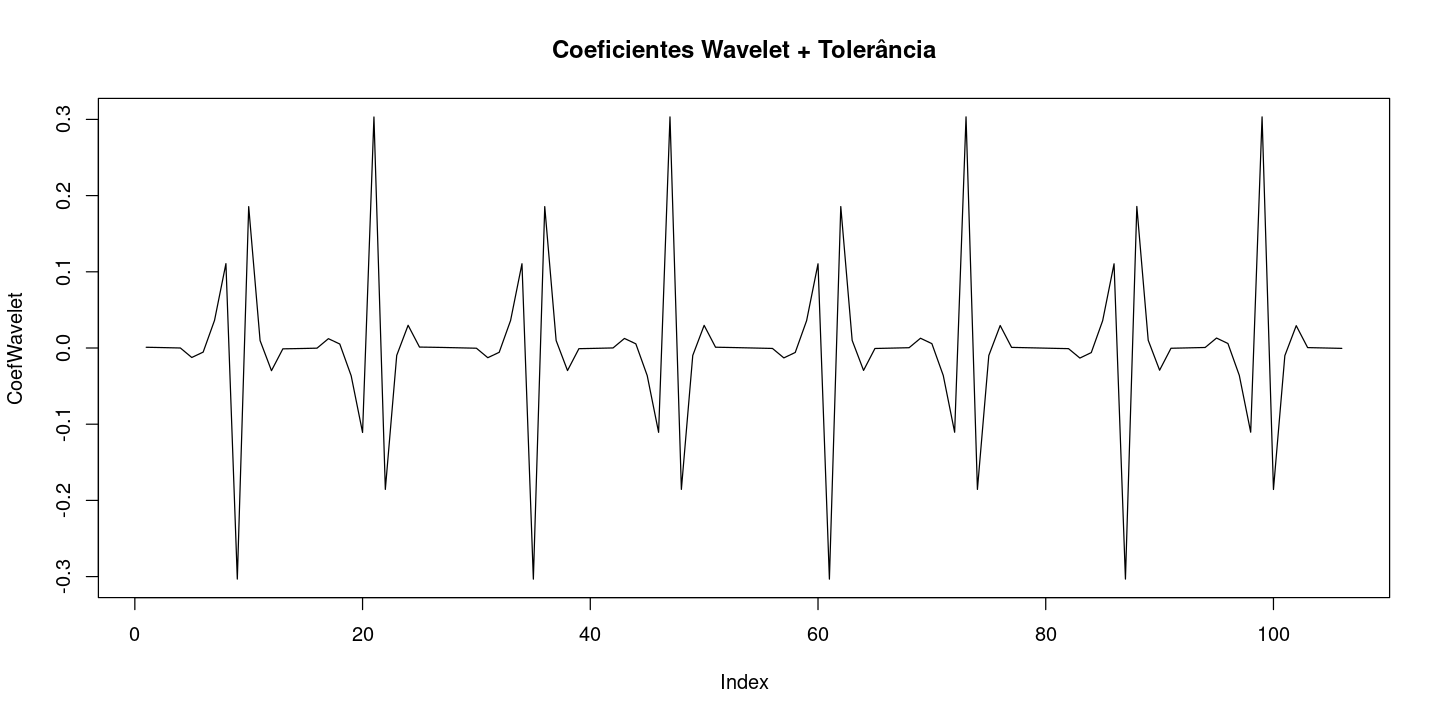

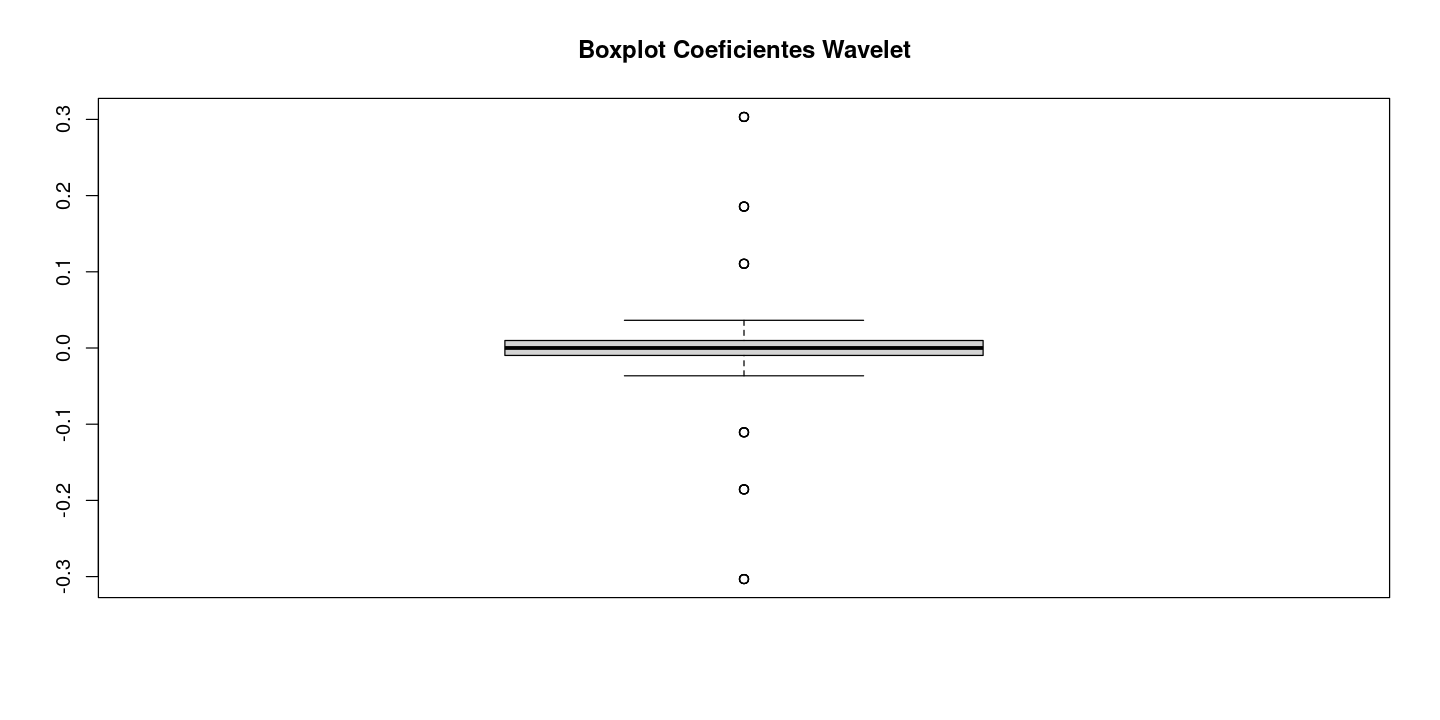

[1] "Candidatos à anomalias:"
 [1]  11  12  13  23  24  25  37  38  39  49  50  51  63  64  65  75  76  77  89
[20]  90  91 101 102 103
[1] "Anomalias por frequência + amplitude:"
NULL
[1] "Anomalias por frequência:"
numeric(0)


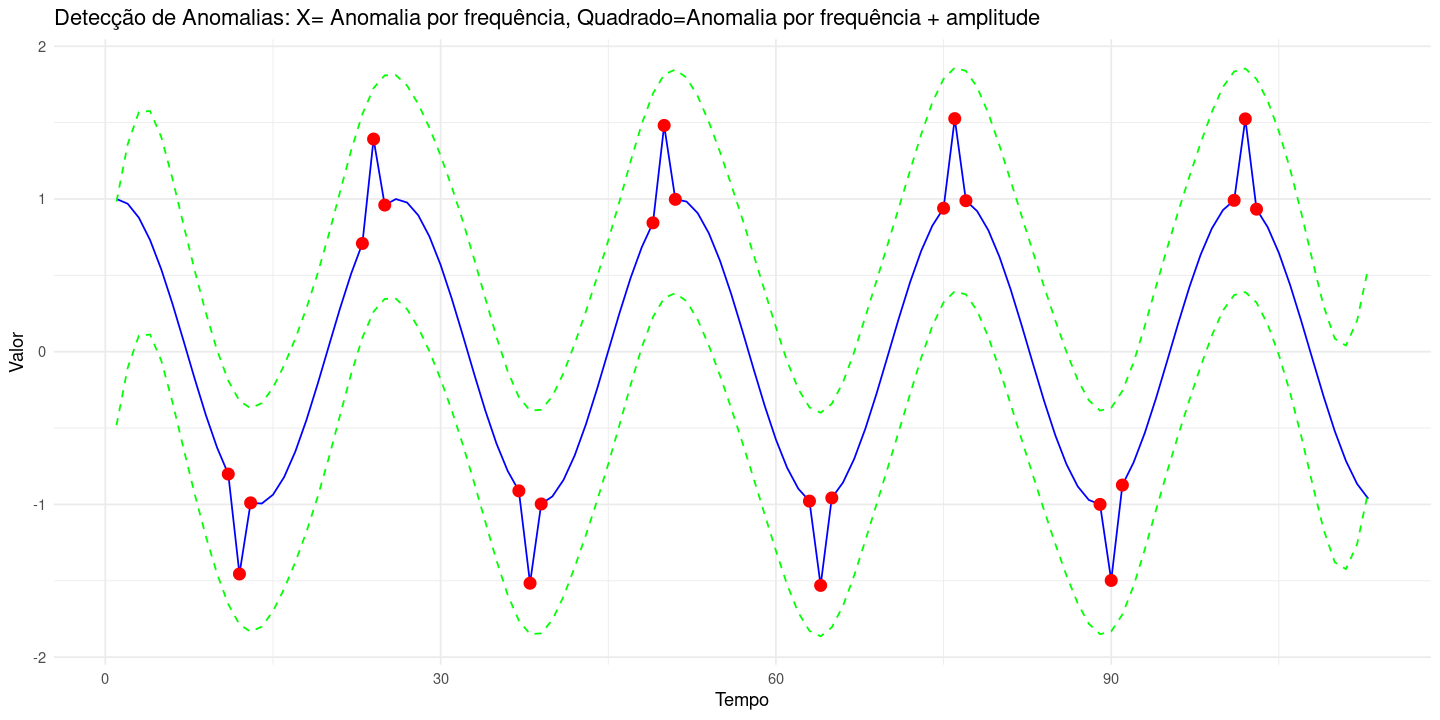

In [2]:
exemplos <- list(har_examples$example1$serie, har_examples$example2$serie, har_examples$example3$serie,
                 har_examples$example4$serie, har_examples$example5$serie, har_examples$example6$serie,
                 har_examples$example7$serie, har_examples$example8$serie, har_examples$example17$serie)

# Tolerância em desvios padrão (1: 68,26%; 2: 95,44%; 3: 99,74%; 4: 99,99%)
desvios <- 2.698 * 2

for (exemplo in exemplos){
  data <- exemplo
    # 1) Realizando a Transformada Wavelet Discreta
    wt <- WaveletT(data, filter="la8") # Opções de filtro: "haar", "d4", "la8", "bl14", "c6"
       
    # 2) Calculando o componente de tendência dos coeficientes Wavelet
    wt_ct <- attr(wt,"wt_obj")
    n <- length(wt_ct@V)
    for (i in 1:length(wt_ct@W)) {
      wt_ct@W[[i]] <- as.matrix(rep(0, length(wt_ct@W[[i]])), ncol=1)
    }
    # 2.1 Calculando a tendência em amplitude com base na transformada Wavelet inversa 
    yhat <- WaveletT.rev(pred=NULL, wt_ct)
    
    # 3) Tratando os coeficientes Waveletwt@W$W1
    CoefWavelet <- wt$W1 
    # 3.1 Desconsiderando APENAS os 6% iniciais do vetor de coeficientes
    descarte <- ceiling(length(CoefWavelet)*0.06)
    CoefWavelet <-  CoefWavelet[-c(1:descarte)]
    #CoefWavelet <-  CoefWavelet[-c((length(CoefWavelet)-descarte+1) : length(CoefWavelet))]

    # 4) Exibindo os coeficientes Wavelet + tolerância
    plot(CoefWavelet, main="Coeficientes Wavelet + Tolerância", type="l")
    cw_tol <-  (desvios * sd(CoefWavelet))
    lines(wt_ct@W$W1 + cw_tol, type="l", col="green")
    lines(wt_ct@W$W1 - cw_tol, type="l", col="green")
    
    # 5) Análise de outliers no vetor de coeficientes Wavelet
    candidatos <- boxplot(CoefWavelet, main = "Boxplot Coeficientes Wavelet")$out
    # 5.1 Exibindo os outliers como candidados a anomalias
    #print("Candidatos à anomalias:")
    #print(candidatos)
    limitecandidato <- min(abs(candidatos))
    # 5.2 Apresenta o menor limiar absoluto dentre os candidatos que atenderam ao critério de distãncia
    #print(paste("Menor limiar absoluto dos candidatos=", limitecandidato))
    
    # 6) Marcação dos candidatos à anomalias
    # 6.1 Utilização do valor limiar automático para identificar as anomalias 
    threshold <- limitecandidato                  
    anomaly_wavelet <- which(abs(wt$W1) >= threshold)
    
    # 6.2 Descarte dos 6% iniciais do vetor de coeficientes
    anomaly_wavelet <- anomaly_wavelet[anomaly_wavelet > descarte]
    #anomaly_wavelet <- anomaly_wavelet[anomaly_wavelet < length(CoefWavelet) -descarte] 
    
    # 8) Ajuste do índice da anomalia para "sincronizar" com a série temporal original (W1 tem aproximadamente
    # a metade dos elementos que a série temporal original)
    anomaly <- (anomaly_wavelet * length(data) / length(wt$W1)) - 4
    anomaly <-  anomaly[anomaly > 0]
    
    # 9) Cálculo da tolerância para os candidatos em relação à amplitude
    # 9.1 Extração das anomalias da série original
    ySemCandidatos <- data
    ySemCandidatos <- ySemCandidatos[-anomaly]
    # 9.1 Extração das anomalias da série prevista (trabsformada Wavelet inverva)
    yhatSemCandidatos <- yhat
    yhatSemCandidatos <- yhatSemCandidatos[-anomaly]
    # 9.2 Cálculo do erro
    E <- abs(mean(ySemCandidatos-yhatSemCandidatos))
    DP <- sd(ySemCandidatos-yhatSemCandidatos)
    # 9.3 Cálvulo da tolerância
    Tolerancia <- (desvios * DP)
    #print(paste("Erro médio sinal original - predição =", E, "SD=", DP))
   
    # 10) Seleção dos candidados pelo critério de frequencia
    anomaly_cw_tol <- which(abs(wt$W1) > cw_tol)
    anomaly_cw_tol <- anomaly_cw_tol[anomaly_cw_tol > descarte]
    anomaly_cw_tol <- (anomaly_cw_tol * length(data) / length(wt$W1)) - 4
    anomaly_cw_tol <- anomaly_cw_tol[anomaly_cw_tol > 0]
    
    # 11) Seleção dos candidados pelo critério de amplitude
    anomaly_ap_tol <- c()
    for(anomalia in anomaly){
        if(data[anomalia] > yhat[anomalia] + Tolerancia || data[anomalia] < yhat[anomalia] - Tolerancia){
            anomaly_ap_tol <- c(anomaly_ap_tol, anomalia)
        }
    }
    
    # 12) Exibição do gráfico com a marcação da anomalia na série temporal original
    t <- 1:length(data)
    anomalia <- ggplot() + 
                geom_line(aes(x=t, y=data), color="blue") +
                #geom_line(aes(x=t, y=yhat), color="green", linetype = "dotted") +
                geom_line(aes(x=t, y=yhat+Tolerancia), color="green", linetype = "dashed") +
                geom_line(aes(x=t, y=yhat-Tolerancia), color="green", linetype = "dashed") +
                geom_point(aes(x=t[anomaly], y=data[anomaly]), color="red", size=3) +
                geom_point(aes(x=t[anomaly_cw_tol], y=data[anomaly_cw_tol]), color="red", size=6, shape=4) +
                geom_point(aes(x=t[anomaly_ap_tol], y=data[anomaly_ap_tol]), color="red", size=6, shape=0) +
                labs(title="Detecção de Anomalias: X= Anomalia por frequência, Quadrado=Anomalia por frequência + amplitude", 
                     x="Tempo", y="Valor") +
                theme_minimal()
    plot(anomalia)
    
    print("Candidatos à anomalias:")
    print(anomaly)
    print("Anomalias por frequência + amplitude:")
    print(anomaly_ap_tol)
    print("Anomalias por frequência:")
    print(anomaly_cw_tol)
}

## Teste com as series  temporais do Janio.

In [3]:
#Install package
library(devtools)
#devtools::install_github("cefet-rj-dal/event_datasets", force=TRUE)
library(dalevents)

In [4]:
#Load a series
data(yahoo_a1)

series <- yahoo_a1$real_1
series2 <- yahoo_a1$real_2
series3 <- yahoo_a1$real_3

#Get information about a series
#?yahoo_a1

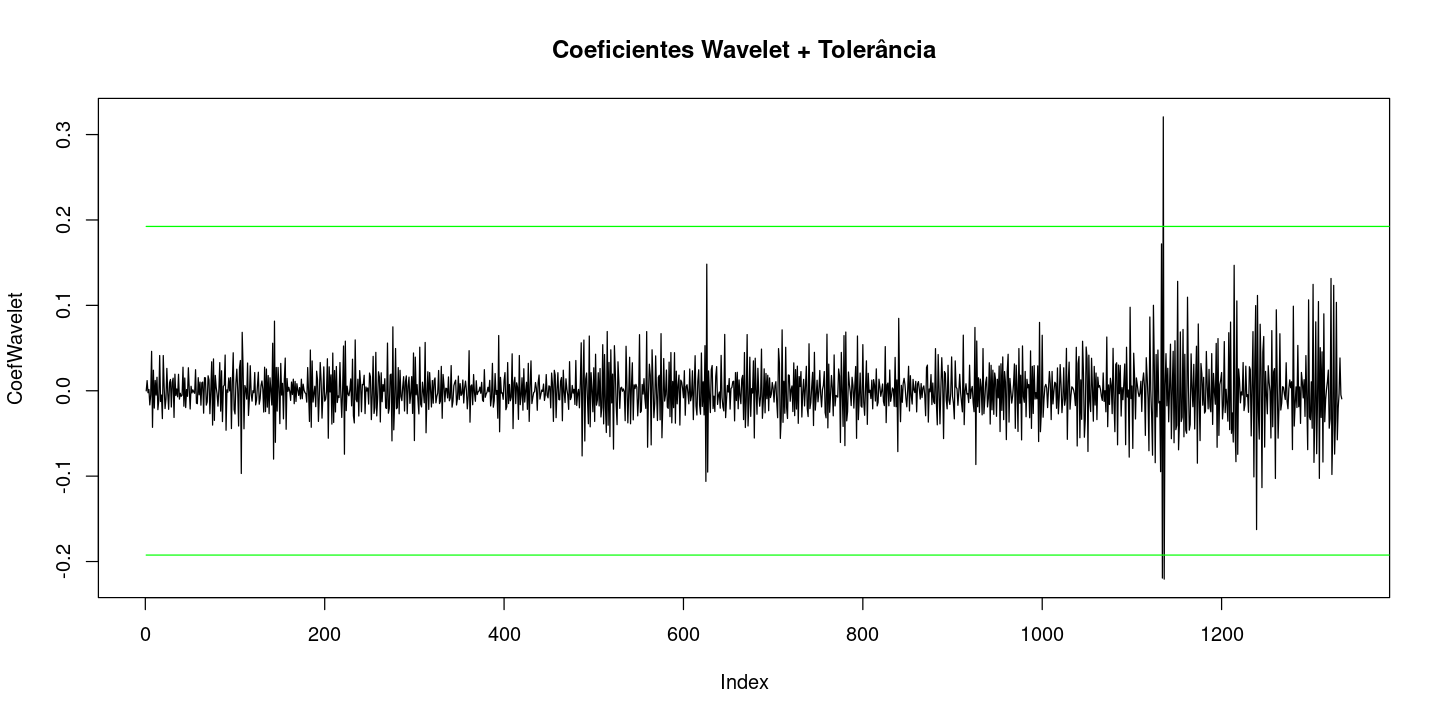

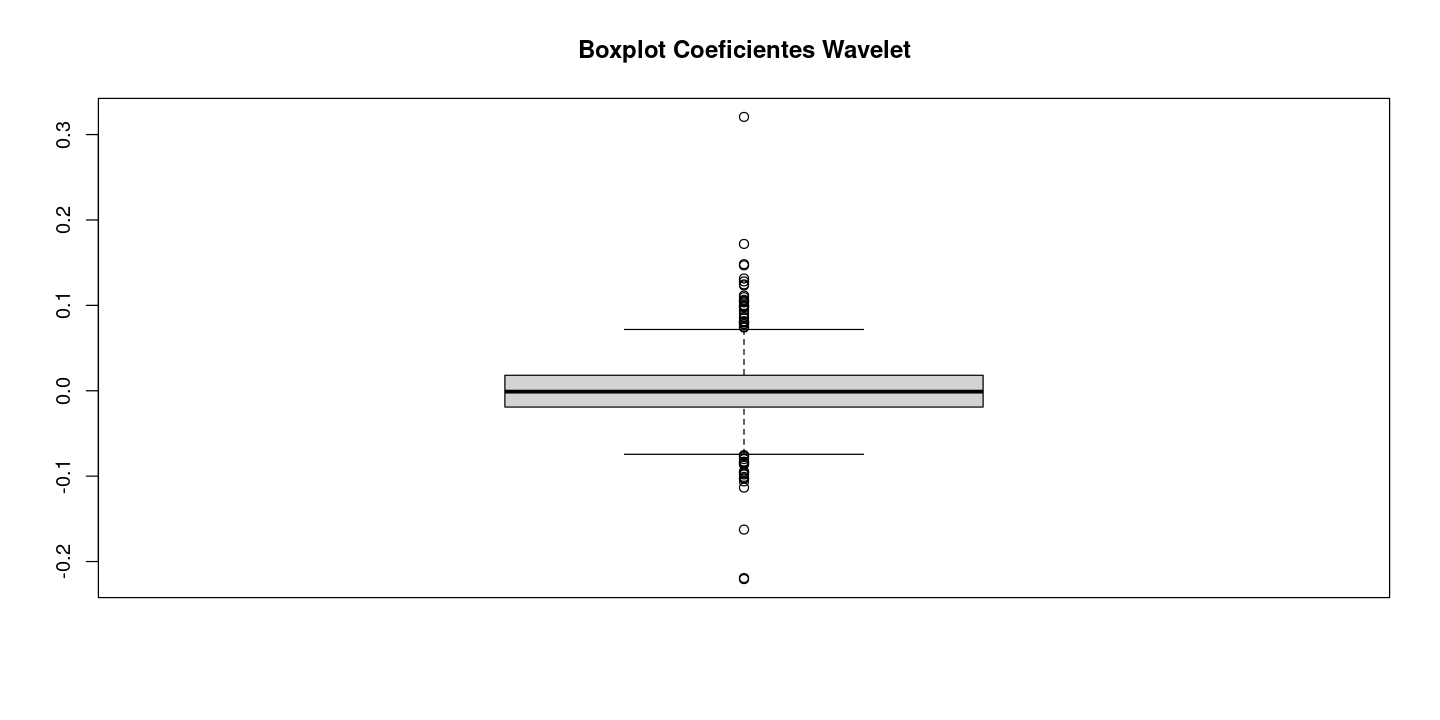

[1] "Candidatos à anomalias:"
 [1]  189  225  226  304  358  569  707  708  709  922 1007 1008 1079 1179 1180
[16] 1202 1205 1206 1208 1214 1215 1216 1217 1218 1233 1244 1255 1256 1292 1296
[31] 1298 1299 1300 1318 1320 1321 1322 1325 1327 1342 1343 1362 1379 1384 1385
[46] 1387 1390 1391 1395 1396 1404 1405 1407 1408 1410
[1] "Anomalias por frequência + amplitude:"
[1] 1215 1216 1217 1218 1321
[1] "Anomalias por frequência:"
[1] 1216 1217 1218
[1] "F1-Score e Matriz de Confusão para frequência + amplitude"
       F1 
0.5714286 
          Reference
Prediction    1    0
         1    2    3
         0    0 1415
[1] "F1-Score e Matriz de Confusão para frequência"
 F1 
0.4 
          Reference
Prediction    1    0
         1    1    2
         0    1 1416
[1] 1215 1217


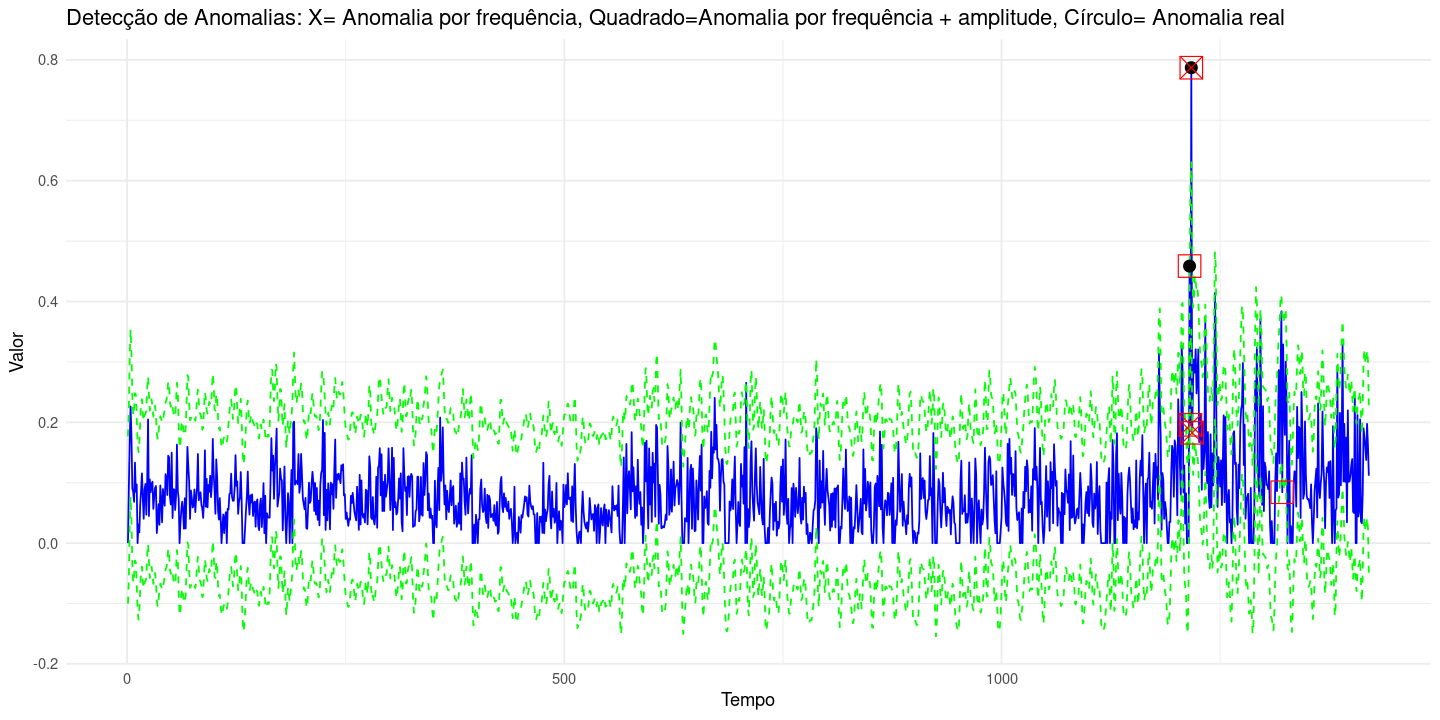

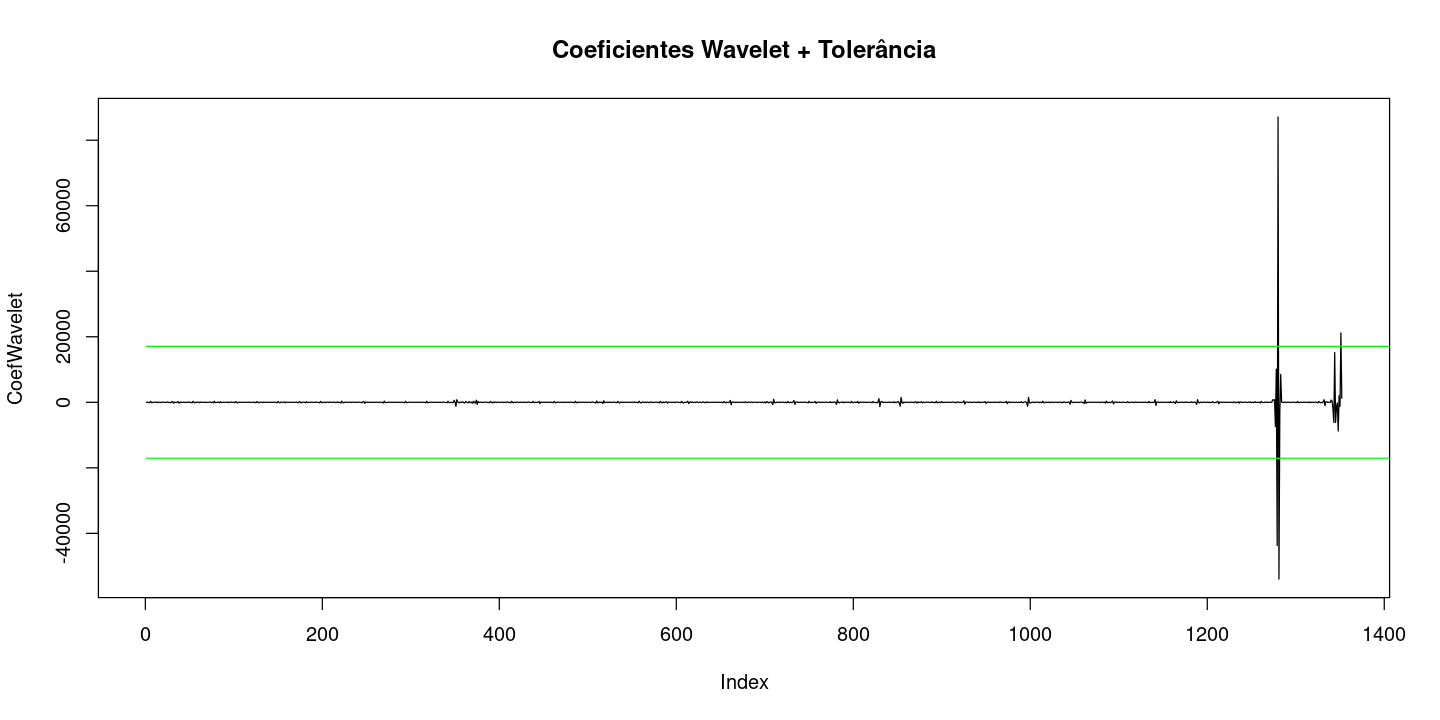

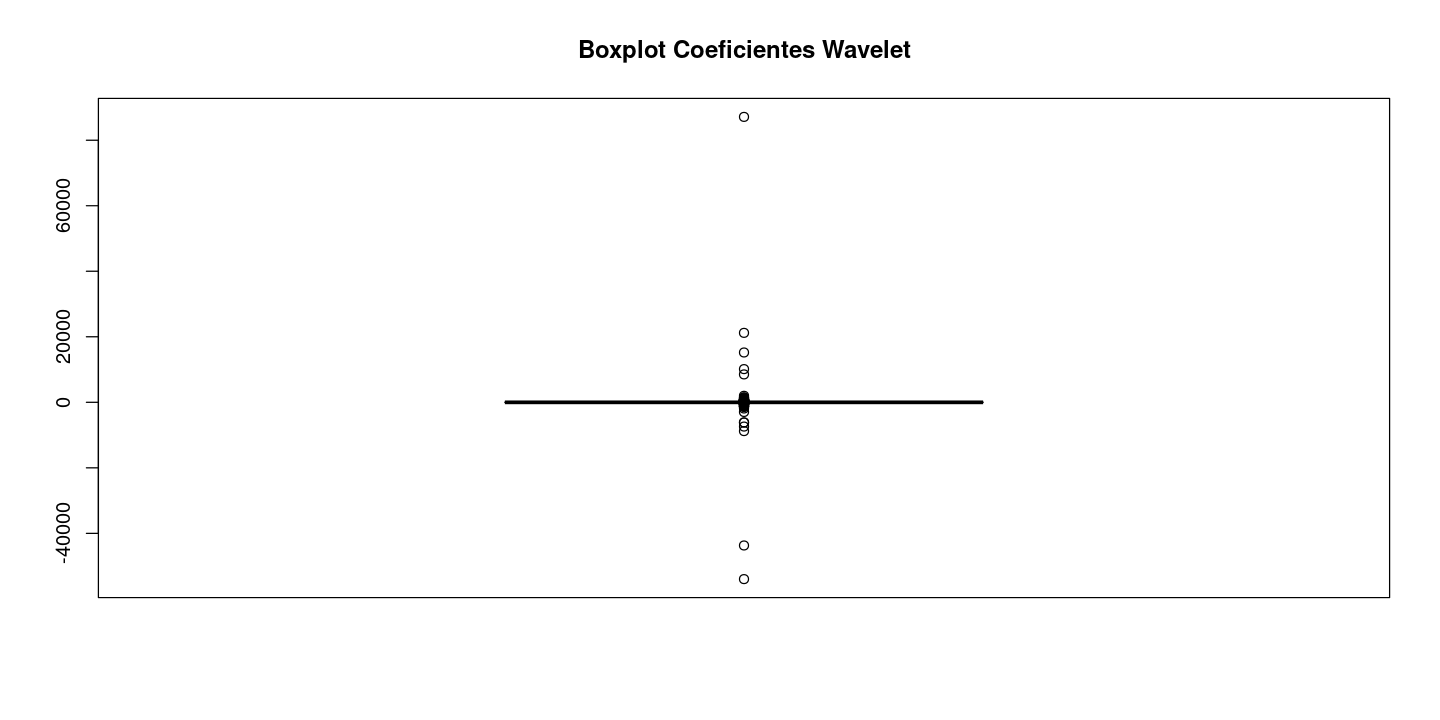

[1] "Candidatos à anomalias:"
  [1]   89  113  115  120  121  137  161  185  187  209  233  257  259  265  281
 [16]  304  305  307  329  330  331  352  353  377  401  425  432  434  435  444
 [31]  445  449  453  454  456  457  458  459  473  475  496  497  499  521  528
 [46]  529  545  569  592  593  600  601  617  619  641  643  664  665  667  672
 [61]  673  689  691  696  697  737  739  744  745  784  785  787  792  793  809
 [76]  816  817  833  840  841  857  864  865  867  881  888  889  905  911  912
 [91]  913  915  934  935  936  937  939  953  955  972  977  983 1008 1009 1032
[106] 1033 1056 1057 1073 1079 1080 1081 1083 1097 1128 1129 1144 1145 1146 1168
[121] 1169 1176 1177 1193 1217 1224 1225 1241 1245 1247 1248 1271 1272 1289 1295
[136] 1296 1319 1337 1343 1344 1357 1358 1359 1360 1361 1362 1363 1364 1365 1366
[151] 1385 1409 1414 1415 1416 1418 1423 1424 1425 1426 1427 1428 1429 1430 1431
[166] 1432 1433 1434 1435
[1] "Anomalias por frequência + amplitude:"
 [1] 1358

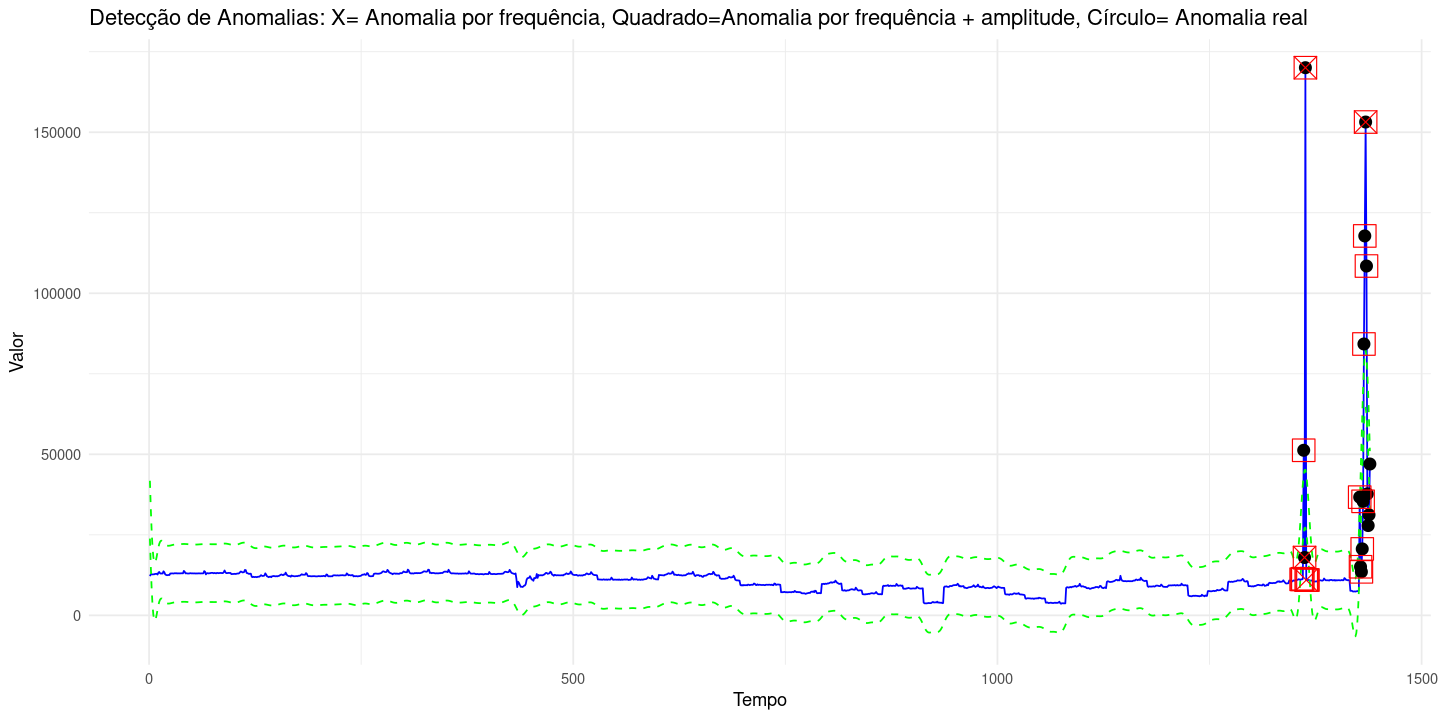

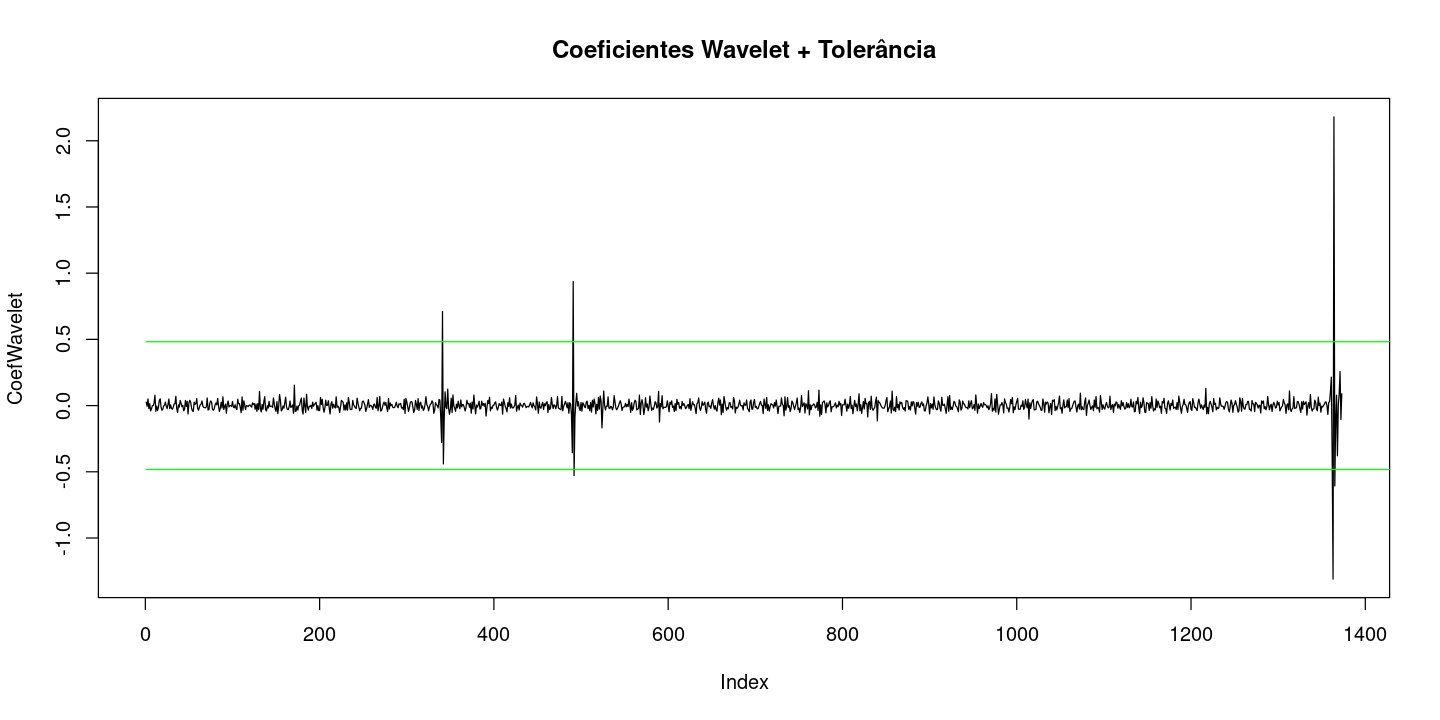

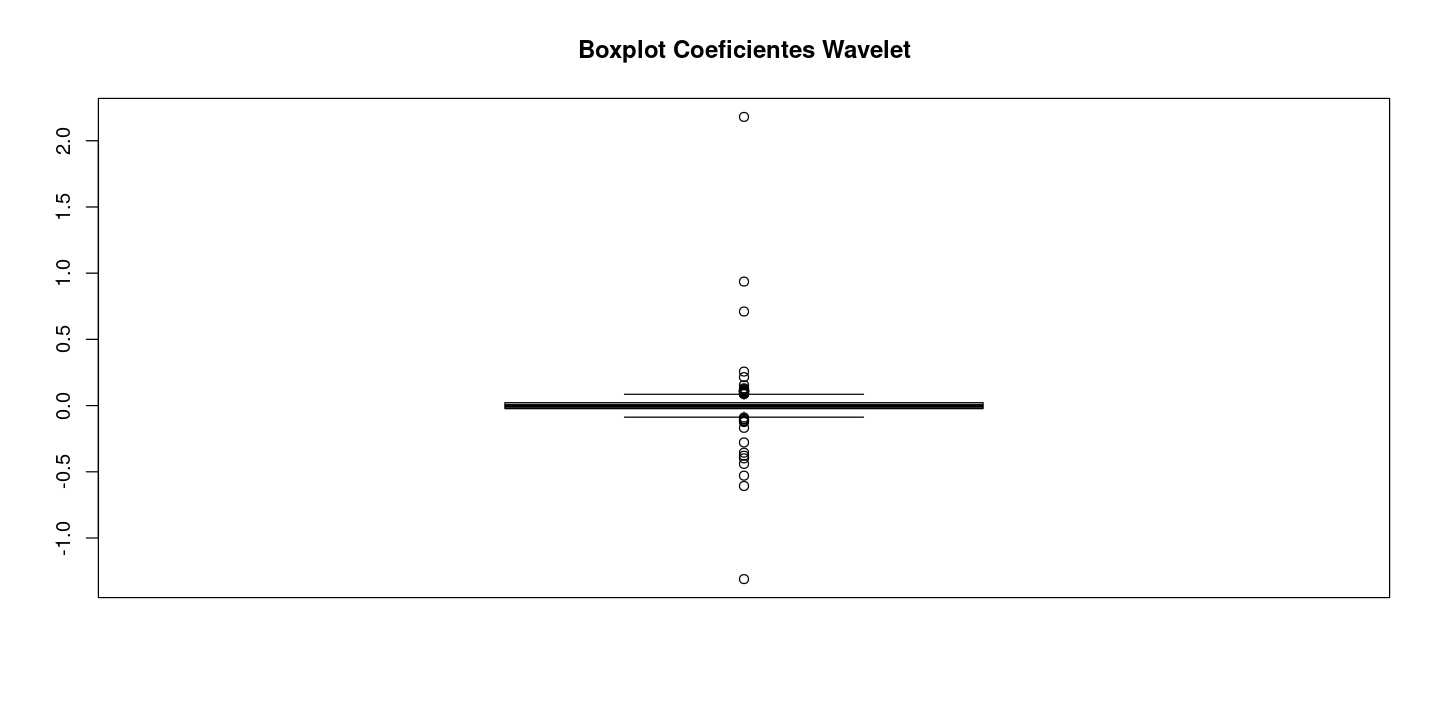

[1] "Candidatos à anomalias:"
 [1]  215  255  424  425  426  427  428  431  574  575  576  579  608  610  673
[16]  674  845  857  903  924  941 1055 1098 1157 1301 1397 1444 1445 1446 1447
[31] 1448 1449 1450 1452 1455 1456 1457
[1] "Anomalias por frequência + amplitude:"
[1]  425  575 1447 1448 1449
[1] "Anomalias por frequência:"
[1]  425  575  576 1447 1448 1449
[1] "F1-Score e Matriz de Confusão para frequência + amplitude"
 F1 
0.3 
          Reference
Prediction    1    0
         1    3    2
         0   12 1444
[1] "F1-Score e Matriz de Confusão para frequência"
       F1 
0.2857143 
          Reference
Prediction    1    0
         1    3    3
         0   12 1443
 [1]  575 1448 1449 1450 1451 1452 1453 1454 1455 1456 1457 1458 1459 1460 1461


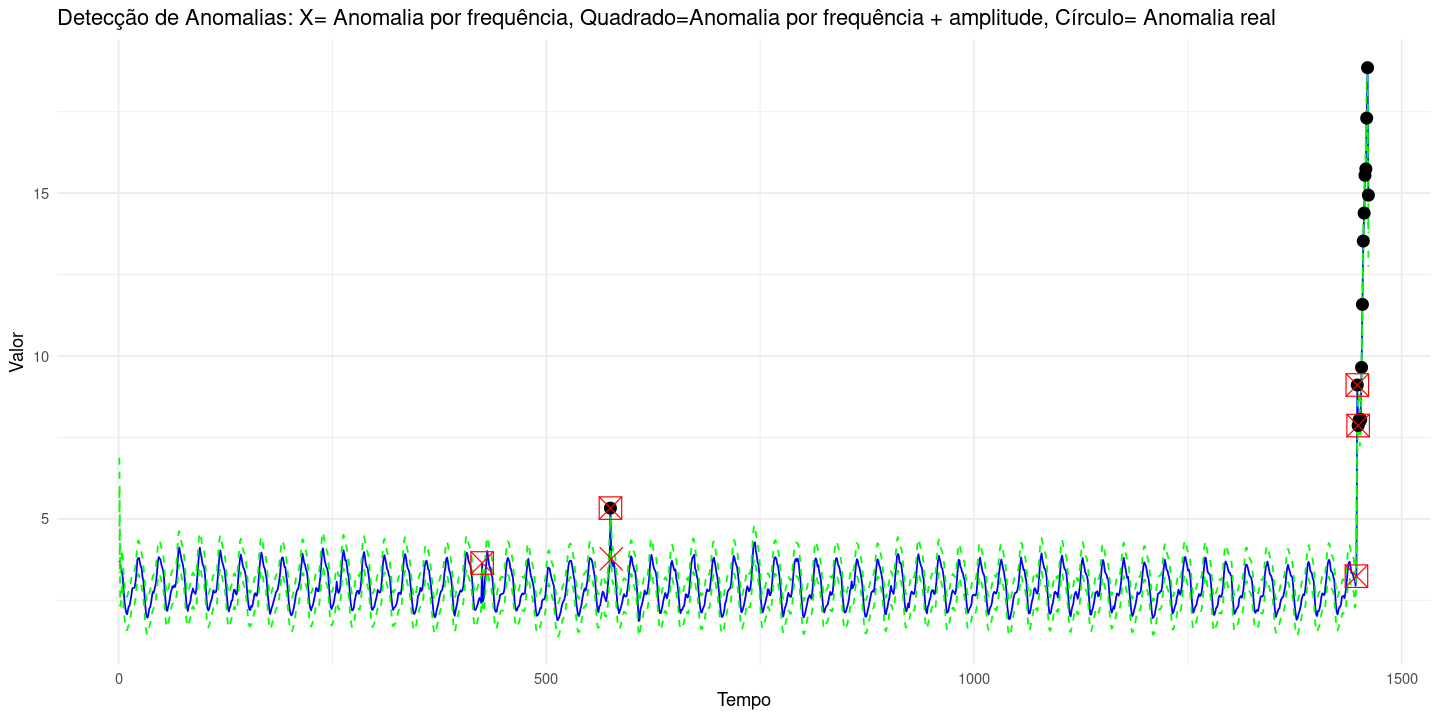

In [5]:
exemplos <- list(series, series2, series3)

# Tolerância em desvios padrão
desvios <- 2.698 *2

for (exemplo in exemplos){
  data <- exemplo$series
  matriz_real <- exemplo$event
  matriz_previsao_cw <- rep(0, length(matriz_real))
  matriz_previsao_ap <- rep(0, length(matriz_real))

    # 1) Realizando a Transformada Wavelet Discreta
    wt <- WaveletT(data, filter="la8") # Opções de filtro: "haar", "d4", "la8", "bl14", "c6"
       
    # 2) Calculando o componente de tendência dos coeficientes Wavelet
    wt_ct <- attr(wt,"wt_obj")
    n <- length(wt_ct@V)
    for (i in 1:length(wt_ct@W)) {
      wt_ct@W[[i]] <- as.matrix(rep(0, length(wt_ct@W[[i]])), ncol=1)
    }
    # 2.1 Calculando a tendência em amplitude com base na transformada Wavelet inversa 
    yhat <- WaveletT.rev(pred=NULL, wt_ct)
    
    # 3) Tratando os coeficientes Waveletwt@W$W1
    CoefWavelet <- wt$W1 
    # 3.1 Desconsiderando APENAS os 6% iniciais do vetor de coeficientes
    descarte <- ceiling(length(CoefWavelet)*0.06)
    CoefWavelet <-  CoefWavelet[-c(1:descarte)]
    #CoefWavelet <-  CoefWavelet[-c((length(CoefWavelet)-descarte+1) : length(CoefWavelet))]

    # 4) Exibindo os coeficientes Wavelet + tolerância
    plot(CoefWavelet, main="Coeficientes Wavelet + Tolerância", type="l")
    cw_tol <- (desvios * sd(CoefWavelet))
    lines(wt_ct@W$W1 + cw_tol, type="l", col="green")
    lines(wt_ct@W$W1 - cw_tol, type="l", col="green")
    
    # 5) Análise de outliers no vetor de coeficientes Wavelet
    candidatos <- boxplot(CoefWavelet, main = "Boxplot Coeficientes Wavelet")$out
    # 5.1 Exibindo os outliers como candidados a anomalias
    #print("Candidatos à anomalias:")
    #print(candidatos)
    limitecandidato <- min(abs(candidatos))
    # 5.2 Apresenta o menor limiar absoluto dentre os candidatos que atenderam ao critério de distãncia
    #print(paste("Menor limiar absoluto dos candidatos=", limitecandidato))
    
    # 6) Marcação dos candidatos à anomalias
    # 6.1 Utilização do valor limiar automático para identificar as anomalias 
    threshold <- limitecandidato                  
    anomaly_wavelet <- which(abs(wt$W1) >= threshold)
    
    # 6.2 Descarte dos 6% iniciais do vetor de coeficientes
    anomaly_wavelet <- anomaly_wavelet[anomaly_wavelet > descarte]
    #anomaly_wavelet <- anomaly_wavelet[anomaly_wavelet < length(CoefWavelet) -descarte] 
    
    # 8) Ajuste do índice da anomalia para "sincronizar" com a série temporal original (W1 tem aproximadamente
    # a metade dos elementos que a série temporal original)
    anomaly <- (anomaly_wavelet * length(data) / length(wt$W1)) - 4
    anomaly <-  anomaly[anomaly > 0]
    
    # 9) Cálculo da tolerância para os candidatos em relação à amplitude
    # 9.1 Extração das anomalias da série original
    ySemCandidatos <- data
    ySemCandidatos <- ySemCandidatos[-anomaly]
    # 9.1 Extração das anomalias da série prevista (trabsformada Wavelet inverva)
    yhatSemCandidatos <- yhat
    yhatSemCandidatos <- yhatSemCandidatos[-anomaly]
    # 9.2 Cálculo do erro
    E <- abs(mean(ySemCandidatos-yhatSemCandidatos))
    DP <- sd(ySemCandidatos-yhatSemCandidatos)
    # 9.3 Cálvulo da tolerância
    Tolerancia <- (desvios * DP)
    #print(paste("Erro médio sinal original - predição =", E, "SD=", DP))
   
    # 10) Seleção dos candidados pelo critério de frequencia
    anomaly_cw_tol <- which(abs(wt$W1) > cw_tol)
    anomaly_cw_tol <- anomaly_cw_tol[anomaly_cw_tol > descarte]
    anomaly_cw_tol <- (anomaly_cw_tol * length(data) / length(wt$W1)) - 4
    anomaly_cw_tol <- anomaly_cw_tol[anomaly_cw_tol > 0]
    
    # 11) Seleção dos candidados pelo critério de amplitude
    anomaly_ap_tol <- c()
    for(anomalia in anomaly){
        if(data[anomalia] > yhat[anomalia] + Tolerancia || data[anomalia] < yhat[anomalia] - Tolerancia){
            anomaly_ap_tol <- c(anomaly_ap_tol, anomalia)
        }
    }
    
    # 12) Criação das matrizes de confusão
    for(i in anomaly_cw_tol){
        matriz_previsao_cw[i] <- 1
    }
    
    for(i in anomaly_ap_tol){
        matriz_previsao_ap[i] <- 1
    }
    
    matriz_cw <- confusionMatrix(factor(matriz_previsao_cw, levels = c("1", "0")), factor(matriz_real, levels = c("1", "0")))
    matriz_ap <- confusionMatrix(factor(matriz_previsao_ap, levels = c("1", "0")), factor(matriz_real, levels = c("1", "0")))
    
    precision_cw <-  matriz_cw$byClass['Pos Pred Value'][2]
    recall_cw <-  matriz_cw$byClass['Sensitivity'][2]
    f1_score_cw <- 2 * (precision_cw * recall_cw) / (precision_cw + recall_cw)
    
    precision_ap <-  matriz_ap$byClass['Pos Pred Value'][2]
    recall_ap <-  matriz_ap$byClass['Sensitivity'][2]
    f1_score_ap <- 2 * (precision_ap * recall_ap) / (precision_ap + recall_ap)
    
    anomalia_real <- c()
    for(i in 1:length(matriz_real)){
        if(matriz_real[i]==1){
            anomalia_real <- c(anomalia_real, i)
            }
    }
    
    # 12) Exibição do gráfico com a marcação da anomalia na série temporal original
    t <- 1:length(data)
    anomalia <- ggplot() + 
                geom_line(aes(x=t, y=data), color="blue") +
                #geom_line(aes(x=t, y=yhat), color="green", linetype = "dotted") +
                geom_line(aes(x=t, y=yhat+Tolerancia), color="green", linetype = "dashed") +
                geom_line(aes(x=t, y=yhat-Tolerancia), color="green", linetype = "dashed") +
                geom_point(aes(x=t[anomalia_real], y=data[anomalia_real]), color="black", size=3) +
                geom_point(aes(x=t[anomaly_cw_tol], y=data[anomaly_cw_tol]), color="red", size=6, shape=4) +
                geom_point(aes(x=t[anomaly_ap_tol], y=data[anomaly_ap_tol]), color="red", size=6, shape=0) +
                labs(title="Detecção de Anomalias: X= Anomalia por frequência, Quadrado=Anomalia por frequência + amplitude, Círculo= Anomalia real", 
                     x="Tempo", y="Valor") +
                theme_minimal()
    plot(anomalia)
    
    print("Candidatos à anomalias:")
    print(anomaly)
    print("Anomalias por frequência + amplitude:")
    print(anomaly_ap_tol)
    print("Anomalias por frequência:")
    print(anomaly_cw_tol)
    print("F1-Score e Matriz de Confusão para frequência + amplitude")
    print(matriz_ap$byClass[7])
    print(matriz_ap$table )
    print("F1-Score e Matriz de Confusão para frequência")
    print(matriz_cw$byClass[7])
    print(matriz_cw$table )
    print(anomalia_real)
}